# Code First Girls - Nanodegree Group Project - Autumn Cohort 2021

# Load Packages
Packages to be used to analyse all questions

In [2]:
# Load packages
import pandas as pd  # To read data
import csv # Saving and reading data
import numpy as np # Used in linear regression
import matplotlib.pyplot as plt  # To visualise
from matplotlib.pylab import rcParams # For data visualisation
rcParams['figure.figsize'] = 15, 12 # Plot size for graphs
import json # for mapping
import folium # for mapping
from folium.plugins import HeatMap # for heatmapping
from functools import reduce # To merge all datasets
from sklearn.linear_model import LinearRegression as lr # Linear Regression
import requests # API calling
from pandas import json_normalize # For API json format, and saving df
import seaborn as sns
from sklearn.model_selection import train_test_split # Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Linear Model

# Question 1 - What is the difference of infrastructure between Rural and Urban areas? 

## Step 1 Loading Data
#### This section of code loads the required data from files and creates dataframes limited to the relevant columns we will be using.

### Loading Data - Ofcom Broadband Data for 2021 
For SuperFast Broadband, Ultra Fast Broadband, and Full Fibre Broadband and download speeds in those areas.

In [81]:
# Dataset 2021 broadband data containing download speeds
broadband_data = pd.read_csv('202105_fixed_laua_coverage_r01.csv', header=0)
# broadband_data.head()

In [82]:
# Broadband Data Set
#     Select specific columns needed: 
#     local authority code, 
#     local authority name, 
#     % of premises that can receive full fibre,
#     % of premises that can receive Superfast broadband, 
#     % of premises that can receive ultrafast broadband,
#     of premises with 0<2Mbit/s download speed, 
#     % of premises with 2<5Mbit/s download speed, 
#     % of premises with 5<10Mbit/s download speed

broadband_data = broadband_data[['laua',
                                 'laua_name',
                                 'Full Fibre availability (% premises)',
                                 'SFBB availability (% premises)',
                                 'UFBB availability (% premises)',
                                 '% of premises with 0<2Mbit/s download speed',
                                 '% of premises with 2<5Mbit/s download speed',
                                 '% of premises with 5<10Mbit/s download speed'
                                ]]
# Change 'laua_name' to 'Name'
broadband_data = broadband_data.rename({'laua_name':'Area'}, axis='columns')
# broadband_data.head()

### Loading Data - 2011 Rural/Urban Classification data

In [83]:
# Loading the 2011 census rural/urban classification data
rural_urban_data = pd.read_excel('RUC11_LAD11_ENv2.xlsx', header=0)
# rural_urban_data.head()

In [84]:
#  Rural and Urban Classification Dataset
# Renaming certain columns for ease of interpretation
rural_urban_data = rural_urban_data.rename({'LAD11NM':'Area',
                                            'RUC11':'Classification',
                                            'RUC11CD':'Numerical classification',
                                            'LAD11CD':'laua'}, axis='columns')
# rural_urban_data.head()

In [85]:
# Select specific columns I need: Local authority code, local authority name,Classification, Numerical classification
rural_urban_data = rural_urban_data[['laua','Area', 'Classification','Numerical classification']]
rural_urban_data.head()

,laua,Area,Classification,Numerical classification
0,NaN,NaN,NaN,NaN
1,E06000001,Hartlepool,Urban with City and Town,4.0
2,E06000002,Middlesbrough,Urban with City and Town,4.0
3,E06000003,Redcar and Cleveland,Urban with Significant Rural (rural including ...,3.0
4,E06000004,Stockton-on-Tees,Urban with City and Town,4.0


### Loading Data - Latitude/Longitude for mapping

In [86]:
# Loading the location data to be used for mapping (latitude and longitude)
location_data = pd.read_csv('area_grid.csv', header=0)
# location_data.head()

In [87]:
# Extracting required data: local authority name, local authority code, latitude, longitude
location_data = location_data[['District', 'District Code', 'Latitude','Longitude']]
# location_data.head()

## Step 2 - Cleaning Data
#### In this section we inspect our dataframes to ensure the data is as expected and check for missing values.

### Cleaning Data - Ofcom Broadband Data for 2021 

In [88]:
# Checking Broadband data
broadband_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 8 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   laua                                          374 non-null    object 
 1   Area                                          374 non-null    object 
 2   Full Fibre availability (% premises)          374 non-null    float64
 3   SFBB availability (% premises)                374 non-null    float64
 4   UFBB availability (% premises)                374 non-null    float64
 5   % of premises with 0<2Mbit/s download speed   374 non-null    float64
 6   % of premises with 2<5Mbit/s download speed   374 non-null    float64
 7   % of premises with 5<10Mbit/s download speed  374 non-null    float64
dtypes: float64(6), object(2)
memory usage: 23.5+ KB


We see that this returns 374 entries, consistent with the number of local authorities in the UK. Our filtered columns do not contain any null values.

Note: the original dataset did contain nulls for some of the other columns but as we will not be using these in our analysis we can proceed using the filtered 'clean' dataset.

### Cleaning Data  - 2011 Rural/Urban Classification data

In [89]:
# Checking rural/urban data
rural_urban_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   laua                      326 non-null    object 
 1   Area                      326 non-null    object 
 2   Classification            326 non-null    object 
 3   Numerical classification  326 non-null    float64
dtypes: float64(1), object(3)
memory usage: 10.4+ KB


We see that this returns 329 entries, this is less than the broadband dataset as we were only able to source data for England and not the whole of the UK, The number of local authorities in England should be 326 so we need to investigate the dataframe further.

We can see that our dataframe contains null values so the code in the next cell returns the rows containing any NaN values.

Dataset for 2021 Broadband data for SuperFast Broadband, Ultra Fast Broadband, and Full Fibre Broadband 

In [90]:
nan_values = rural_urban_data[rural_urban_data.isna().any(axis=1)]
print (nan_values)

    laua Area Classification  Numerical classification
0    NaN  NaN            NaN                       NaN
327  NaN  NaN            NaN                       NaN
328  NaN  NaN            NaN                       NaN


We see that column indices 0,327,328 contain completely blank rows so we can drop these to produce our clean dataset

In [91]:
rural_urban_data = rural_urban_data.drop(index=[0,327,328])
rural_urban_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 1 to 326
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   laua                      326 non-null    object 
 1   Area                      326 non-null    object 
 2   Classification            326 non-null    object 
 3   Numerical classification  326 non-null    float64
dtypes: float64(1), object(3)
memory usage: 12.7+ KB


### Cleaning Data -  Latitude/Longitude for mapping

In [92]:
# Checking location data
location_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   District       374 non-null    object 
 1   District Code  374 non-null    object 
 2   Latitude       374 non-null    float64
 3   Longitude      374 non-null    float64
dtypes: float64(2), object(2)
memory usage: 11.8+ KB


We see that this returns 374 entries, again consistent with the number of local authorities across the whole of the UK Our filtered columns do not contain any null values note: the original dataset did contain nulls for some of the other columns but as we will not be using these in our analysis we can proceed using the filtered 'clean' dataset.

### Merging Datasets
In this section we will merge our data sets to produce a single dataframe for ease of analysis.

### Merging - Joining the broadband and rural/urban datasets

In [93]:
bb_ru_merged = pd.merge(broadband_data,
                  rural_urban_data,
                  on ='laua',
                  how ='inner')
bb_ru_merged.head()

,laua,Area_x,Full Fibre availability (% premises),SFBB availability (% premises),UFBB availability (% premises),% of premises with 0<2Mbit/s download speed,% of premises with 2<5Mbit/s download speed,% of premises with 5<10Mbit/s download speed,Area_y,Classification,Numerical classification
0,E07000223,ADUR,1.5,98.7,85.4,0.0,0.0,0.1,Adur,Urban with City and Town,4.0
1,E07000026,ALLERDALE,3.2,92.6,3.2,1.2,1.0,1.0,Allerdale,Mainly Rural (rural including hub towns >=80%),1.0
2,E07000032,AMBER VALLEY,24.3,95.2,27.4,0.1,0.2,0.4,Amber Valley,Urban with Minor Conurbation,5.0
3,E07000224,ARUN,8.3,96.5,10.6,0.1,0.1,0.2,Arun,Urban with City and Town,4.0
4,E07000170,ASHFIELD,3.9,98.0,86.6,0.0,0.4,0.1,Ashfield,Urban with City and Town,4.0


In [94]:
bb_ru_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 0 to 294
Data columns (total 11 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   laua                                          295 non-null    object 
 1   Area_x                                        295 non-null    object 
 2   Full Fibre availability (% premises)          295 non-null    float64
 3   SFBB availability (% premises)                295 non-null    float64
 4   UFBB availability (% premises)                295 non-null    float64
 5   % of premises with 0<2Mbit/s download speed   295 non-null    float64
 6   % of premises with 2<5Mbit/s download speed   295 non-null    float64
 7   % of premises with 5<10Mbit/s download speed  295 non-null    float64
 8   Area_y                                        295 non-null    object 
 9   Classification                                295 non-null    obj

### Merging - Joining the broadband and rural/urban data with the location data

In [95]:
# Joining the broadband and rural/urban data with the location data
bb_ru_loc_merged = pd.merge(bb_ru_merged,location_data,left_on ='laua',right_on = 'District Code',how ='inner')
bb_ru_loc_merged.head()

,laua,Area_x,Full Fibre availability (% premises),SFBB availability (% premises),UFBB availability (% premises),% of premises with 0<2Mbit/s download speed,% of premises with 2<5Mbit/s download speed,% of premises with 5<10Mbit/s download speed,Area_y,Classification,Numerical classification,District,District Code,Latitude,Longitude
0,E07000223,ADUR,1.5,98.7,85.4,0.0,0.0,0.1,Adur,Urban with City and Town,4.0,Adur,E07000223,50.833099,-0.285009
1,E07000026,ALLERDALE,3.2,92.6,3.2,1.2,1.0,1.0,Allerdale,Mainly Rural (rural including hub towns >=80%),1.0,Allerdale,E07000026,54.713100,-3.361350
2,E07000032,AMBER VALLEY,24.3,95.2,27.4,0.1,0.2,0.4,Amber Valley,Urban with Minor Conurbation,5.0,Amber Valley,E07000032,53.037701,-1.424460
3,E07000224,ARUN,8.3,96.5,10.6,0.1,0.1,0.2,Arun,Urban with City and Town,4.0,Arun,E07000224,50.808701,-0.597137
4,E07000170,ASHFIELD,3.9,98.0,86.6,0.0,0.4,0.1,Ashfield,Urban with City and Town,4.0,Ashfield,E07000170,53.087299,-1.248920


In [96]:
bb_ru_loc_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 0 to 294
Data columns (total 15 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   laua                                          295 non-null    object 
 1   Area_x                                        295 non-null    object 
 2   Full Fibre availability (% premises)          295 non-null    float64
 3   SFBB availability (% premises)                295 non-null    float64
 4   UFBB availability (% premises)                295 non-null    float64
 5   % of premises with 0<2Mbit/s download speed   295 non-null    float64
 6   % of premises with 2<5Mbit/s download speed   295 non-null    float64
 7   % of premises with 5<10Mbit/s download speed  295 non-null    float64
 8   Area_y                                        295 non-null    object 
 9   Classification                                295 non-null    obj

## Step 3 - Analysis & Visualisation
In this section we investigate the merged datasets in order to identify disparities between broadband availability across different types of location (rural or urban)

### Availability of different broadband connections
In this section we investigate the availability of three different 'types' of broadband connection:

Full Fibre - The fastest and most recently rolled out option
UFBB (UltraFast Broadband) - older & slower 
SFBB (Superfast Broadband) - oldest and slowest connections 

We will aim to show the availability of each option in the 6 urban/rural classification categories
Listed in order from most urban to most rural these are:

Urban with Major Conurbation	
Urban with Minor Conurbation	
Urban with City and Town
Urban with Significant Rural 	
Largely Rural 	
Mainly Rural 

Here we group the dataset by classification category and return the average (mean) availability of each of the 3 connection types. The resulting dataframes have been re-indexed to order from most urban to most rural


In [97]:
meanFF = bb_ru_merged.groupby(['Classification'], as_index=False)['Full Fibre availability (% premises)'].mean()
meanFF=meanFF.reindex([3,4,2,5,0,1])

meanSFBB = bb_ru_merged.groupby(['Classification'], as_index=False)['SFBB availability (% premises)'].mean()
meanSFBB=meanSFBB.reindex([3,4,2,5,0,1])

meanUFBB = bb_ru_merged.groupby(['Classification'], as_index=False)['UFBB availability (% premises)'].mean()
meanUFBB=meanUFBB.reindex([3,4,2,5,0,1])


In [98]:
meanFF

,Classification,Full Fibre availability (% premises)
3,Urban with Major Conurbation,23.514865
4,Urban with Minor Conurbation,24.222222
2,Urban with City and Town,18.313793
5,Urban with Significant Rural (rural including ...,16.293478
0,Largely Rural (rural including hub towns 50-79%),17.844444
1,Mainly Rural (rural including hub towns >=80%),16.786047


In [99]:
meanSFBB

,Classification,SFBB availability (% premises)
3,Urban with Major Conurbation,96.325676
4,Urban with Minor Conurbation,97.600000
2,Urban with City and Town,97.086207
5,Urban with Significant Rural (rural including ...,94.723913
0,Largely Rural (rural including hub towns 50-79%),92.997222
1,Mainly Rural (rural including hub towns >=80%),90.611628


In [100]:
meanUFBB

,Classification,UFBB availability (% premises)
3,Urban with Major Conurbation,77.408108
4,Urban with Minor Conurbation,67.966667
2,Urban with City and Town,71.037931
5,Urban with Significant Rural (rural including ...,48.367391
0,Largely Rural (rural including hub towns 50-79%),35.688889
1,Mainly Rural (rural including hub towns >=80%),25.327907


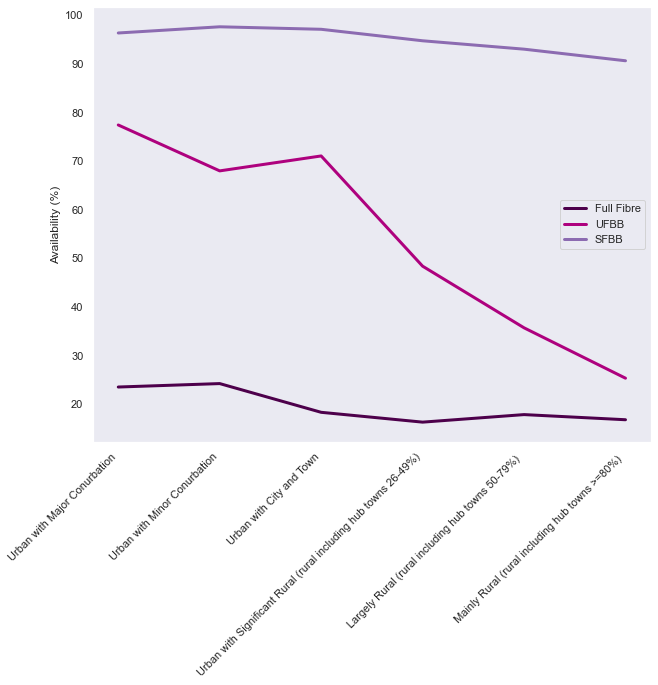

In [108]:
# Visualisation: This plot enables us to visualise these results.

plt.subplots(1,1,figsize=(10,8))
plt.plot(meanFF['Classification'],meanFF['Full Fibre availability (% premises)'],label ='Full Fibre', linewidth=3, color='#4d004b')
plt.plot(meanUFBB['Classification'],meanUFBB['UFBB availability (% premises)'],label ='UFBB', linewidth=3, color='#ae017e')
plt.plot(meanSFBB['Classification'],meanSFBB['SFBB availability (% premises)'],label ='SFBB', linewidth=3, color='#8c6bb1')
plt.xticks(rotation=45,ha='right')
plt.ylabel('Availability (%)')
plt.legend()
plt.grid()
plt.show()

Analysis: The plot shows the trends well, the oldest option (SFBB) has achieved good coverage across all types of area and the newest (Full Fibre) has only attained around 25% coverage in the most urbanised regions. 
All broadband options show a general trend of coverage decreasing as regions become more rural, this is particularly evident in the UFBB coverage line.

### Areas with low-speed connections

In this section we consider how low download speeds can affect peoples internet experience.
One thing highlighted during the pandemic was the importance of high quality connections particularly for people working from home and students who need to access online learning.
Video conferencing is a particularly important tool for these users with various platforms recommending minimum download speeds around 8MBps.
In this section we aim to identify areas that do not meet this requirement and may therefore struggle to access vital tools for work and online learning.

In [24]:
'''
This code filters the merged dataset to return local authoritiy areas that have a significant percentage of premises that 
do not meet the required minimum download speed of 8 mbps.
When viewing the dataset as a whole we notice that the percentages are relatively low 
so we have defined 'significant' as >=1% of the premises.
'''

low_speed = bb_ru_loc_merged[(bb_ru_loc_merged['% of premises with 0<2Mbit/s download speed'] >1) | (bb_ru_loc_merged['% of premises with 2<5Mbit/s download speed'] >1) |(bb_ru_loc_merged['% of premises with 5<10Mbit/s download speed'] >1)]

# We see from the results there are 44 areas returned.
low_speed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 1 to 283
Data columns (total 15 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   laua                                          44 non-null     object 
 1   Area_x                                        44 non-null     object 
 2   Full Fibre availability (% premises)          44 non-null     float64
 3   SFBB availability (% premises)                44 non-null     float64
 4   UFBB availability (% premises)                44 non-null     float64
 5   % of premises with 0<2Mbit/s download speed   44 non-null     float64
 6   % of premises with 2<5Mbit/s download speed   44 non-null     float64
 7   % of premises with 5<10Mbit/s download speed  44 non-null     float64
 8   Area_y                                        44 non-null     object 
 9   Classification                                44 non-null     obje

In [25]:
# Viewing the filtered low-speed dataset, uncomment to view
# low_speed.head(44)

### Visualisation/Analysis:
The histogram below shows the count of areas that do not meet minimum speed requirements by classification,
we see clear correlation to area type with most rural areas having the highest count of inadequate speeds.

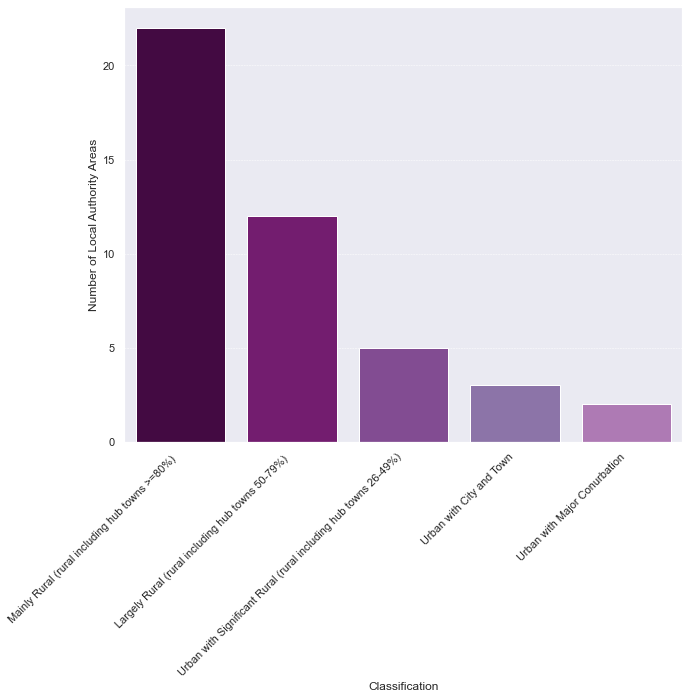

In [107]:
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(x='Classification', data = low_speed,order = low_speed['Classification'].value_counts().index, palette=['#4d004b',"#810f7c", '#88419d', '#8c6bb1', '#B670BE' ])
plt.xticks(rotation=45,ha='right')
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.ylabel('Number of Local Authority Areas')
plt.show()

### Visualising low speed areas on a map

In this section we visualise the areas identified previously where there are potential issues with low-speed connectivity 
by plotting on a map of the UK.

In [27]:
# Importing map of the UK to plot our data onto
ukmap = folium.Map(location = [54.76999101318324, -2.8478385244334445], zoom_start = 5.5) 

In [28]:
# Display the data from the filtered low-speed dataset
# Simplifying the dots on the map to be easier to view

from folium.plugins import MarkerCluster

l1 = []
l2 = []

mcluster = MarkerCluster().add_to(ukmap)
for a in low_speed.index:
    folium.Marker(location = [low_speed.loc[a,"Latitude"], low_speed.loc[a,"Longitude"]],
                  zoom_start = 5.5,
                  tooltip = low_speed.loc[a,"Area_x"]).add_to(mcluster)
    l1.append(low_speed.loc[a,"Latitude"])
    l2.append(low_speed.loc[a,"Longitude"])
            
ukmap

# Question 2 - Can we identify trends over time? 

## Step 1 Loading Data
This section of code loads the required data from files and creates dataframes limited to the relevant columns we will be using. 
Dataset for Ofcom Broadband for the period 2016 - 2021

### Loading Data - Ofcom Broadband Data 2016 - 2021

## Load in datasets
1) Calling the dataset for each year
2) Preparing each dataset for the merge (deleting unneeded columns, renaming & reformatting columns to indicate the year)
3) Merging the datasets into a single file for internet

In [29]:
# Load in datasets
Six = pd.read_csv('2016_data.csv')
Seven = pd.read_csv('2017_data.csv')
Eight = pd.read_csv('2018_data.csv')
Nine = pd.read_csv('2019_data.csv')
Twenty = pd.read_csv('2020_data.csv')
Twenty1 = pd.read_csv('2021_data.csv')

In [30]:
# 2016 data
# Simplify datasets to common variables 
#     local authority name, 
#     % of premises that can receive full fibre,
#     % of premises that can receive Superfast broadband, 
#     % of premises that can receive ultrafast broadband,
#     of premises with 0<2Mbit/s download speed, 
#     % of premises with 2<5Mbit/s download speed, 
#     % of premises with 5<10Mbit/s download speed
six = Six[['laua_name',
              'SFBB availability (% premises)',
              'UFBB availability (% premises)',                      
        ]]
# Rename variables
clean_six = six.rename({'laua_name': 'Area',
                        'SFBB availability (% premises)': '2016 SFBB availability (% premises)',
                        'UFBB availability (% premises)': '2016 UFBB availability (% premises)'}, axis='columns')
# Capitalize area string
clean_six['Area']=clean_six['Area'].str.upper()
#clean_six # viewing data

In [31]:
# 2017 data
# Simplify datasets to common variables
seven = Seven[['laua_name',
              'SFBB availability (% premises)',
              'UFBB availability (% premises)',                        
        ]]
# Rename variables
clean_seven = seven.rename({'laua_name': 'Area',
                        'SFBB availability (% premises)': '2017 SFBB availability (% premises)',
                        'UFBB availability (% premises)': '2017 UFBB availability (% premises)'}, axis='columns')
# Capitalize area string
clean_seven['Area']=clean_seven['Area'].str.upper()
#clean_seven  # viewing data

In [32]:
# 2018 data
# Simplify datasets to common variables
eight = Eight[['laua_name',
              'SFBB availability (% premises)',
              'UFBB availability (% premises)',                      
        ]]
# Rename variables
clean_eight = eight.rename({'laua_name': 'Area',
                        'SFBB availability (% premises)': '2018 SFBB availability (% premises)',
                        'UFBB availability (% premises)': '2018 UFBB availability (% premises)'}, axis='columns')
# Capitalize area string
clean_eight['Area']=clean_eight['Area'].str.upper()
# clean_eight  # viewing data

In [33]:
# 2019 data
# Simplify datasets to common variables
nine = Nine[['laua_name',
              'SFBB availability (% premises)',
              'UFBB availability (% premises)',            
        ]]
# Rename variables
clean_nine = nine.rename({'laua_name': 'Area',
                        'SFBB availability (% premises)': '2019 SFBB availability (% premises)',
                        'UFBB availability (% premises)': '2019 UFBB availability (% premises)'}, axis='columns')

# Capitalize area string
clean_nine['Area']=clean_nine['Area'].str.upper()
# clean_nine  # viewing data

In [34]:
# 2020 data
# Simplify datasets to common variables
twenty = Twenty[['laua_name',
              'SFBB availability (% premises)',
              'UFBB availability (% premises)',            
        ]]
# twenty

# Renaming certain columns for ease of interpretation
clean_twenty = twenty.rename({'laua_name': 'Area',
                        'SFBB availability (% premises)': '2020 SFBB availability (% premises)',
                        'UFBB availability (% premises)': '2020 UFBB availability (% premises)'}, axis='columns')

# Capitalize area string
clean_twenty['Area']=clean_twenty['Area'].str.upper()
# clean_twenty  # viewing data

In [35]:
# 2021 data
# Simplify datasets to common variables
twenty1 = Twenty1[['laua_name',
              'SFBB availability (% premises)',
              'UFBB availability (% premises)',            
        ]]

# Renaming certain columns for ease of interpretation
clean_21 = twenty1.rename({'laua_name': 'Area',
                        'SFBB availability (% premises)': '2021 SFBB availability (% premises)',
                        'UFBB availability (% premises)': '2021 UFBB availability (% premises)'}, axis='columns')

# Capitalize area string
clean_21['Area']=clean_21['Area'].str.upper()
# clean_21  # viewing data

In [36]:
# Merge all datasets together

dfs = [clean_six, clean_seven, clean_eight, clean_nine, clean_twenty, clean_21] # Define which datasets

internet = reduce(lambda left, right: pd.merge (left,right,on = ['Area'], how = 'outer'), dfs) # Merge
# internet # view data

### Loading Data - Income Data from NOMIS API
This section is for acquiring the income data for the periods 2016-2021 for each region in Great Britain. This is conveyed through labelling of the api calling below. 
The datasets were called with different API links. This was due to difficulties in calling all the data from the API with timeouts. When trying to call all regions using 1 API link, only the first 240 rows of data. However, there should have be 4000+ rows across all regions. To complete this, we separated the regions into datasets of 240 rows or less so that all datapoints could be compiled.
These were then normalised into dataframes.

In [37]:
############### Calling API's ##############
#Region - Yorkshire
url_yorkshire="https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939394,1811939398,1811939399,1811939387,1811939395,1811939382,1811939388,1811939389,1811939383,1811939400,1811939401,1811939384,1811939385,1811939390,1811939396,1811939391...1811939393,1811939397,1811939402&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_y_1 = requests.get(url_yorkshire)
data_yorkshire = response_y_1.json()

url_york = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939386&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_y_2 = requests.get(url_york)
data_york = response_y_2.json()
     
#Region - East
url_east1 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939517,1811939484,1811939473,1811939485,1811939510,1811939486,1811939511,1811939496,1811939479,1811939487,1811939474,1811939488,1811939489,1811939497,1811939480,1811939499,1811939524,1811939490,1811939481,1811939512&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_e1 = requests.get(url_east1)
data_east1 = response_e1.json()

url_east2 ="https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939491,1811939500,1811939482,1811939519,1811939513,1811939475,1811939492,1811939520,1811939501,1811939514,1811939515,1811939476,1811939493,1811939483,1811939516,1811939477,1811939503,1811939505,1811939494,1811939506&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_e2 = requests.get(url_east2)
data_east2 = response_e2.json()

url_east3 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939478,1811939495,1811939507,1811939509,1811939525&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_e3 = requests.get(url_east3)
data_east3 = response_e3.json()

#Region - East Midlands
url_east_mid_1 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939407,1811939436,1811939437,1811939415,1811939408,1811939422,1811939438,1811939416,1811939409,1811939403,1811939410,1811939423,1811939411,1811939439,1811939417,1811939412,1811939418&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_em_1 = requests.get(url_east_mid_1)
data_eastmid_1 = response_em_1.json()

url_east_mid_2 ="https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939404,1811939424,1811939440,1811939419,1811939441,1811939413,1811939425,1811939768,1811939420,1811939405,1811939421,1811939442,1811939406,1811939414,1811939426...1811939428,1811939769&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_em_2 = requests.get(url_east_mid_2)
data_eastmid_2 = response_em_2.json()

#Region - West Midlands
url_west_mid_1 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939460,1811939467,1811939447,1811939461,1811939462,1811939448,1811939443,1811939449,1811939468,1811939450,1811939455,1811939456,1811939469,1811939457,1811939463,1811939444,1811939464,1811939451...1811939453&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_wm_1 = requests.get(url_west_mid_1)
data_westmid_1 = response_wm_1.json()

url_west_mid_2 ="https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939445,1811939458,1811939454,1811939446,1811939465,1811939459,1811939466,1811939470...1811939472&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_wm_2 = requests.get(url_west_mid_2)
data_westmid_2= response_wm_2.json()
                            
#Region - North East
url_ne = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939330,1811939329,1811939338,1811939331,1811939332,1811939339,1811939340,1811939334,1811939335,1811939341,1811939336,1811939342&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_ne = requests.get(url_ne)
data_ne = response_ne.json()
                            
#Region - North West
url_nw_1 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939349,1811939350,1811939343,1811939344,1811939355,1811939365,1811939356,1811939351,1811939345,1811939346,1811939366,1811939352,1811939353,1811939367,1811939347,1811939368,1811939377,1811939369,1811939378,1811939357&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_nw_1 = requests.get(url_nw_1)
data_nw_1 = response_nw_1.json()
                            
url_nw_2 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939358,1811939370...1811939372,1811939359,1811939373,1811939360,1811939379,1811939354,1811939374,1811939380,1811939361...1811939363,1811939348,1811939375,1811939364,1811939381,1811939376&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_nw_2 = requests.get(url_nw_2)
data_nw_2 = response_nw_2.json()
                            
#Region - South East
url_se_1 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939621,1811939622,1811939592,1811939581,1811939559,1811939560,1811939575,1811939593,1811939605,1811939623,1811939624,1811939594,1811939595,1811939582,1811939576,1811939583,1811939610,1811939611,1811939584,1811939599&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_se_1 = requests.get(url_se_1)
data_se_1 = response_se_1.json()

url_se_2 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939585,1811939596,1811939612,1811939586,1811939577,1811939587,1811939625,1811939561,1811939578,1811939597,1811939562,1811939626,1811939563,1811939613,1811939588,1811939606,1811939564,1811939565,1811939614,1811939579&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_se_2 = requests.get(url_se_2)
data_se_2 = response_se_2.json()

url_se_3 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939615,1811939589,1811939598,1811939566,1811939607,1811939567,1811939616,1811939617,1811939601,1811939618,1811939590,1811939602...1811939604,1811939608,1811939619,1811939580,1811939568,1811939609&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_se_3 = requests.get(url_se_3)
data_se_3 = response_se_3.json()

url_se_4 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939591,1811939569,1811939620,1811939570,1811939627&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_se_4 = requests.get(url_se_4)
data_se_4 = response_se_4.json()

#Region - South West
url_sw_1 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939628,1811939649,1811939630,1811939656,1811939631,1811939657,1811939655,1811939640,1811939641,1811939658,1811939659,1811939632,1811939662,1811939642,1811939643,1811939633,1811939634,1811939663,1811939667&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_sw_1 = requests.get(url_sw_1)
data_sw_1 = response_sw_1.json()

url_sw_2 ="https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939636,1811939644,1811939664,1811939660,1811939637,1811939645,1811939661,1811939638,1811939646,1811939647,1811939639&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_sw_2 = requests.get(url_sw_2)
data_sw_2 = response_sw_2.json()
                            
#Region - London
url_ldn_1 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939540...1811939544,1811939526,1811939527,1811939545...1811939548,1811939528...1811939530,1811939549...1811939552&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_ldn_1 = requests.get(url_ldn_1)
data_ldn_1 = response_ldn_1.json()
                            
url_ldn_2 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939531,1811939532,1811939553,1811939533,1811939534,1811939554,1811939535,1811939555,1811939556,1811939536,1811939557,1811939537,1811939558,1811939538,1811939539&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_ldn_2 = requests.get(url_ldn_2)
data_ldn_2 = response_ldn_2.json()

#Region - Wales
url_wales_1 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939689,1811939680,1811939688,1811939683,1811939677,1811939675,1811939670...1811939672,1811939669,1811939668,1811939687,1811939691,1811939679,1811939692&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_wales_1 = requests.get(url_wales_1)
data_wales_1 = response_wales_1.json()
                            
url_wales_2 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939676,1811939674,1811939685,1811939678,1811939690,1811939682,1811939673&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_wales_2 = requests.get(url_wales_2)
data_wales_2 = response_wales_2.json()
                            
#Region - Scotland
url_scot_1 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939693...1811939696,1811939704,1811939697...1811939703,1811939708,1811939710,1811939712,1811939713&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_scot_1 = requests.get(url_scot_1)
data_scot_1 = response_scot_1.json()

url_scot_2 = "https://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.json?geography=1811939714...1811939716,1811939707,1811939717,1811939719,1811939720,1811939722...1811939730&date=latestMINUS5-latest&sex=8&item=2&pay=7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
response_scot_2 = requests.get(url_scot_2)
data_scot_2 = response_scot_2.json()

# Call the below for an example of api response
# data_scot_2

In [38]:
# Normalising Json data into dataframe format. Removing irrelevant section of data
yorkshire_df = (json_normalize(data_yorkshire, 'obs'))
york_df = (json_normalize(data_york, 'obs'))
east1_df = (json_normalize(data_east1, 'obs'))
east2_df = (json_normalize(data_east2, 'obs'))
east3_df = (json_normalize(data_east3, 'obs'))
eastmid1_df = (json_normalize(data_eastmid_1, 'obs'))
eastmid2_df = (json_normalize(data_eastmid_2, 'obs'))
westmid1_df = (json_normalize(data_westmid_1, 'obs'))
westmid2_df = (json_normalize(data_westmid_2, 'obs'))
northeast_df = (json_normalize(data_ne, 'obs'))
northwest_1_df = (json_normalize(data_nw_1, 'obs'))
northwest_2_df = (json_normalize(data_nw_2, 'obs'))
southwest_1_df = (json_normalize(data_sw_1, 'obs'))
southwest_2_df = (json_normalize(data_sw_2, 'obs'))
southeast_1_df = (json_normalize(data_se_1, 'obs'))
southeast_2_df = (json_normalize(data_se_2, 'obs'))
southeast_3_df = (json_normalize(data_se_3, 'obs'))
southeast_4_df = (json_normalize(data_se_4, 'obs'))
ldn_1_df = (json_normalize(data_ldn_1, 'obs'))
ldn_2_df = (json_normalize(data_ldn_2, 'obs'))
wales_1_df = (json_normalize(data_wales_1, 'obs'))
wales_2_df = (json_normalize(data_wales_2, 'obs'))
scot_1_df = (json_normalize(data_scot_1, 'obs'))
scot_2_df = (json_normalize(data_scot_2, 'obs'))

In [39]:
# Adding an additional column to dataframes, 
# this will be required later on when grouping the data
yorkshire_df.insert(0, 'Region', 'Yorkshire')
york_df.insert(0, 'Region', 'Yorkshire')
east1_df.insert(0, 'Region', 'East')
east2_df.insert(0, 'Region', 'East')
east3_df.insert(0, 'Region', 'East')
eastmid1_df.insert(0, 'Region', 'East Midlands')
eastmid2_df.insert(0, 'Region', 'East Midlands')
westmid1_df.insert(0, 'Region', 'West Midlands')
westmid2_df.insert(0, 'Region', 'West Midlands')
northeast_df.insert(0, 'Region', 'North East')
northwest_1_df.insert(0, 'Region', 'North West')
northwest_2_df.insert(0, 'Region', 'North West')
southwest_1_df.insert(0, 'Region', 'South West')
southwest_2_df.insert(0, 'Region', 'South West')
southeast_1_df.insert(0, 'Region', 'South East')
southeast_2_df.insert(0, 'Region', 'South East')
southeast_3_df.insert(0, 'Region', 'South East')
southeast_4_df.insert(0, 'Region', 'South East')
ldn_1_df.insert(0, 'Region', 'London')
ldn_2_df.insert(0, 'Region', 'London')
wales_1_df.insert(0, 'Region', 'Wales')
wales_2_df.insert(0, 'Region', 'Wales')
scot_1_df.insert(0, 'Region', 'Scotland')
scot_2_df.insert(0, 'Region', 'Scotland')

In [40]:
# Saving/merging all income dataframes to 1 csv file, reading data from csv
pd.concat([yorkshire_df, york_df, 
           east1_df, east2_df, 
           east3_df, eastmid1_df, 
           eastmid2_df, westmid1_df, 
           westmid2_df, northeast_df, 
           northwest_1_df, northwest_2_df, 
           southwest_1_df, southwest_2_df,
           southeast_1_df, southeast_2_df, 
           southeast_3_df, southeast_4_df, 
           ldn_1_df, ldn_2_df, wales_1_df, wales_2_df,
           scot_1_df, scot_2_df ]).to_csv('Uncleaned Data.csv',
                                     index = False, header = True) 
uncleaned_data = pd.read_csv('Uncleaned Data.csv') #reading csv

In [41]:
# Modifying dataset for ease of interpretation
#Select specific columns needed: 
data = uncleaned_data[['Region',
                       'geography.description',
                 'measures.description',
                 'time.value', 
                 'obs_value.value',
                 'obs_status.description']]
# Renaming certain columns for ease of interpretation
data = data.rename({'geography.description':'Area',
                 'measures.description': 'Accuracy',
                 'time.value': 'Date', 
                 'obs_value.value':'Observed Annual Income',
                 'obs_status.description': 'Information'},  axis='columns')
# Capitalise Area string
data['Area']=data['Area'].str.upper()
#data #viewing dataframe
data.to_csv('Income Data.csv')

## Step 2 - Cleaning Data
#### In this section we inspect our dataframes to ensure the data is as expected and check for missing values.

After analysing the income csv, it is clear some rows are missing information or have unreliable information. This is notably expressed in the 'Information' column (previously 'obs_status.description'). Futhermore, the values in the rows with the confidence value are not expressing an income. These are not relevant so must be removed.

In [42]:
#Removing all rows with unreliable variables/missing information
data = data[data.Information == "Normal Value"]

# Removing all confidence variables
confidence_vals = data[data.Accuracy == "Confidence"]
data = data[data['Accuracy'] != 'Confidence']

data.to_csv('Semi-Cleaned Data.csv') # Saving data to csv for backup

data

,Region,Area,Accuracy,Date,Observed Annual Income,Information
0,Yorkshire,BARNSLEY,Value,2016,24313.0,Normal Value
1,Yorkshire,BARNSLEY,Value,2017,25107.0,Normal Value
2,Yorkshire,BARNSLEY,Value,2018,25370.0,Normal Value
3,Yorkshire,BARNSLEY,Value,2019,26466.0,Normal Value
4,Yorkshire,BARNSLEY,Value,2020,27181.0,Normal Value
...,...,...,...,...,...,...
4345,Scotland,WEST LOTHIAN,Value,2017,28034.0,Normal Value
4346,Scotland,WEST LOTHIAN,Value,2018,28723.0,Normal Value
4347,Scotland,WEST LOTHIAN,Value,2019,29245.0,Normal Value
4348,Scotland,WEST LOTHIAN,Value,2020,31044.0,Normal Value


In [43]:
# Sorting Income Data by Area and Date
data = data.sort_values(["Area", "Date"], ascending = (True, True))

In [44]:
# Saving Cleaned Income Data
data.reset_index(drop=True)
data.to_csv('Cleaned Income Data.csv', index=False)
income_data = pd.read_csv('Cleaned Income Data.csv')
income_data

,Region,Area,Accuracy,Date,Observed Annual Income,Information
0,Scotland,ABERDEEN CITY,Value,2016,29350.0,Normal Value
1,Scotland,ABERDEEN CITY,Value,2017,28500.0,Normal Value
2,Scotland,ABERDEEN CITY,Value,2018,29829.0,Normal Value
3,Scotland,ABERDEEN CITY,Value,2019,30426.0,Normal Value
4,Scotland,ABERDEEN CITY,Value,2020,30615.0,Normal Value
...,...,...,...,...,...,...
2089,Yorkshire,YORK,Value,2017,25956.0,Normal Value
2090,Yorkshire,YORK,Value,2018,26688.0,Normal Value
2091,Yorkshire,YORK,Value,2019,28555.0,Normal Value
2092,Yorkshire,YORK,Value,2020,30054.0,Normal Value


### Merging Datasets
In this section we will merge our data sets to produce two dataframes for ease of analysis. One dataframe will be merged into the wide format (one row per area, with internet split into separate columns) and into the long format (one row per area per year with internet split into two columns). Up until this point, income was in the wide dataformat and internet in the long data format, so the first step is to make them the same.
These will be used for different types of analyses.

In [45]:
# Prepare income data for wide merge (wide dataframe)
income_wide = income_data.pivot(index=('Area', 'Region'), columns='Date', values='Observed Annual Income')
income = income_wide.rename_axis(None, axis=1).reset_index()
income

,Area,Region,2016,2017,2018,2019,2020,2021
0,ABERDEEN CITY,Scotland,29350.0,28500.0,29829.0,30426.0,30615.0,29949.0
1,ABERDEENSHIRE,Scotland,29887.0,29434.0,30877.0,32539.0,33970.0,32605.0
2,ADUR,South East,24645.0,24527.0,26771.0,27919.0,30250.0,NaN
3,ALLERDALE,North West,29315.0,29363.0,29730.0,30474.0,33339.0,35461.0
4,AMBER VALLEY,East Midlands,27832.0,30031.0,29696.0,29602.0,33614.0,31174.0
...,...,...,...,...,...,...,...,...
356,WREXHAM,Wales,25845.0,25296.0,27225.0,28953.0,29282.0,27793.0
357,WYCHAVON,West Midlands,28019.0,28968.0,29998.0,30723.0,28601.0,28189.0
358,WYRE,North West,24620.0,NaN,25191.0,26497.0,27240.0,29379.0
359,WYRE FOREST,West Midlands,25259.0,25060.0,26024.0,27233.0,30212.0,29010.0


In [46]:
# Merging both datasets into a wide data format for Question 3
merged_wide = pd.merge(internet,income, on = "Area")
merged_wide = merged_wide.reset_index(drop = True)
merged_wide = merged_wide.set_index(["Region", "Area"])
merged_wide

2016 SFBB availability (% premises)  \
Region        Area                                                             
South East    THANET                                                    96.0   
              ADUR                                                      99.0   
              ARUN                                                      94.0   
East Midlands ASHFIELD                                                  97.0   
West Midlands COVENTRY                                                  91.0   
...                                                                      ...   
South West    DORSET                                                     NaN   
East          EAST SUFFOLK                                               NaN   
South West    SOMERSET WEST AND TAUNTON                                  NaN   
East          WEST SUFFOLK                                               NaN   
South East    BUCKINGHAMSHIRE                                            NaN   

                                         2016 UFBB availability (% premises)  \
Region        Area                                                             
South East    THANET                                                     0.0   
              ADUR                                                       0.0   
              ARUN                                                       0.0   
East Midlands ASHFIELD                                                   0.0   
West Midlands COVENTRY                                                   0.0   
...                                                                      ...   
South West    DORSET                                                     NaN   
East          EAST SUFFOLK                                               NaN   
South West    SOMERSET WEST AND TAUNTON                                  NaN   
East          WEST SUFFOLK                                               NaN   
South East    BUCKINGHAMSHIRE                                            NaN   

                                         2017 SFBB availability (% premises)  \
Region        Area                                                             
South East    THANET                                                    96.0   
              ADUR                                                      29.0   
              ARUN                                                      93.0   
East Midlands ASHFIELD                                                  98.0   
West Midlands COVENTRY                                                  34.0   
...                                                                      ...   
South West    DORSET                                                     NaN   
East          EAST SUFFOLK                                               NaN   
South West    SOMERSET WEST AND TAUNTON                                  NaN   
East          WEST SUFFOLK                                               NaN   
South East    BUCKINGHAMSHIRE                                            NaN   

                                         2017 UFBB availability (% premises)  \
Region        Area                                                             
South East    THANET                                                     0.0   
              ADUR                                                      70.0   
              ARUN                                                       1.0   
East Midlands ASHFIELD                                                   0.0   
West Midlands COVENTRY                                                  57.0   
...                                                                      ...   
South West    DORSET                                                     NaN   
East          EAST SUFFOLK                                               NaN   
South West    SOMERSET WEST AND TAUNTON                                  NaN   
East          WEST SUFFOLK            

In [47]:
# Sorting merged data by Region and Area
merged_wide = merged_wide.sort_values(["Region", "Area"], ascending = (True, True))

In [48]:
# Further clean data by removing NAs 
merged_wide = merged_wide.dropna()
merged_wide

2016 SFBB availability (% premises)  \
Region    Area                                             
East      BASILDON                                  91.0   
          BEDFORD                                   87.0   
          BRAINTREE                                 68.0   
          BRECKLAND                                 77.0   
          BROADLAND                                 84.0   
...                                                  ...   
Yorkshire RYEDALE                                   72.0   
          SELBY                                     77.0   
          SHEFFIELD                                 86.0   
          WAKEFIELD                                 93.0   
          YORK                                      81.0   

                     2016 UFBB availability (% premises)  \
Region    Area                                             
East      BASILDON                                   1.0   
          BEDFORD                                    1.0   
          BRAINTREE                                  0.0   
          BRECKLAND                                  0.0   
          BROADLAND                                  0.0   
...                                                  ...   
Yorkshire RYEDALE                                    3.0   
          SELBY                                      6.0   
          SHEFFIELD                                  1.0   
          WAKEFIELD                                  0.0   
          YORK                                       8.0   

                     2017 SFBB availability (% premises)  \
Region    Area                                             
East      BASILDON                                  35.0   
          BEDFORD                                   57.0   
          BRAINTREE                                 76.0   
          BRECKLAND                                 80.0   
          BROADLAND                                 62.0   
...                                                  ...   
Yorkshire RYEDALE                                   75.0   
          SELBY                                     79.0   
          SHEFFIELD                                 51.0   
          WAKEFIELD                                 62.0   
          YORK                                      42.0   

                     2017 UFBB availability (% premises)  \
Region    Area                                             
East      BASILDON                                  57.0   
          BEDFORD                                   34.0   
          BRAINTREE                                  0.0   
          BRECKLAND                                  0.0   
          BROADLAND                                 24.0   
...                                                  ...   
Yorkshire RYEDALE                                    5.0   
          SELBY                                      7.0   
          SHEFFIELD                                 38.0   
          WAKEFIELD                                 31.0   
          YORK                                      50.0   

                     2018 SFBB availability (% premises)  \
Region    Area                                             
East      BASILDON                                  28.2   
          BEDFORD                                   23.8   
          BRAINTREE                                 82.3   
          BRECKLAND                                 82.4   
          BROADLAND                                 55.1   
...                                                  ...   
Yorkshire RYEDALE                                   76.7   
          SELBY                                     79.9   
          SHEFFIELD                                 56.3   
          WAKEFIELD                                 62.0   
          YORK                                      22.2   

                     2018 UFBB availability (% premises)  \
Region    Area                                          

In [49]:
# Resetting index to ensure Region and Area are considered as columns 
merged_wide = merged_wide.reset_index()

In [50]:
# Prepare internet data for long merge, rename data to ensure it is interpretable
data_long = merged_wide.rename({'2016 SFBB availability (% premises)': 'SFBB2016',
                           '2017 SFBB availability (% premises)': 'SFBB2017',
                           '2018 SFBB availability (% premises)': 'SFBB2018',
                           '2019 SFBB availability (% premises)': 'SFBB2019',
                           '2020 SFBB availability (% premises)': 'SFBB2020',
                           '2021 SFBB availability (% premises)': 'SFBB2021',
                           '2016 UFBB availability (% premises)': 'UFBB2016',
                           '2017 UFBB availability (% premises)': 'UFBB2017',
                           '2018 UFBB availability (% premises)': 'UFBB2018',
                           '2019 UFBB availability (% premises)': 'UFBB2019',
                           '2020 UFBB availability (% premises)': 'UFBB2020',
                           '2021 UFBB availability (% premises)': 'UFBB2021',
                            2016: 'Income2016',
                            2017: 'Income2017',
                            2018: 'Income2018',
                            2019: 'Income2019',
                            2020: 'Income2020',
                            2021: 'Income2021'}, axis='columns')
data_long

,Region,Area,SFBB2016,UFBB2016,SFBB2017,UFBB2017,SFBB2018,UFBB2018,SFBB2019,UFBB2019,SFBB2020,UFBB2020,SFBB2021,UFBB2021,Income2016,Income2017,Income2018,Income2019,Income2020,Income2021
0,East,BASILDON,91.0,1.0,35.0,57.0,28.2,66.6,29.1,66.9,96.7,69.5,97.9,77.6,30560.0,29839.0,31084.0,32748.0,32597.0,32745.0
1,East,BEDFORD,87.0,1.0,57.0,34.0,23.8,71.7,26.6,69.5,96.5,70.2,97.0,72.3,29564.0,30250.0,29741.0,31624.0,34562.0,31036.0
2,East,BRAINTREE,68.0,0.0,76.0,0.0,82.3,0.8,85.1,2.5,89.2,4.9,93.2,12.9,31481.0,31793.0,32464.0,33681.0,33294.0,31945.0
3,East,BRECKLAND,77.0,0.0,80.0,0.0,82.4,1.3,83.4,3.8,88.7,4.5,90.7,17.6,24329.0,24050.0,26041.0,26208.0,26582.0,26960.0
4,East,BROADLAND,84.0,0.0,62.0,24.0,55.1,35.2,55.2,37.0,93.0,37.4,94.1,40.1,27525.0,27417.0,29091.0,30717.0,32001.0,30400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,Yorkshire,RYEDALE,72.0,3.0,75.0,5.0,76.7,4.4,75.6,5.8,82.6,6.9,83.3,7.6,23173.0,22951.0,24650.0,26298.0,26326.0,26069.0
298,Yorkshire,SELBY,77.0,6.0,79.0,7.0,79.9,7.4,78.9,9.4,89.3,11.5,92.4,19.6,28898.0,29588.0,31303.0,32195.0,34106.0,33062.0
299,Yorkshire,SHEFFIELD,86.0,1.0,51.0,38.0,56.3,37.2,49.6,43.9,95.0,44.9,96.0,47.8,26069.0,26897.0,27665.0,28438.0,28360.0,30625.0
300,Yorkshire,WAKEFIELD,93.0,0.0,62.0,31.0,62.0,32.5,51.5,43.2,95.3,46.7,95.9,55.3,24287.0,24933.0,26033.0,26632.0,26106.0,28166.0


We want the datapoints in our wide and long data to be exactly the same (after dropping columns with NA values), therefore we are creating our long format dataset from the wide dataset.

In [51]:
# Merge income_long and internet_long
merged_long = pd.wide_to_long(data_long, ["SFBB", "UFBB", "Income"], i = "Area", j = "Year")
merged_long

,,Region,SFBB,UFBB,Income
Area,Year,,,,
BASILDON,2016,East,91.0,1.0,30560.0
BEDFORD,2016,East,87.0,1.0,29564.0
BRAINTREE,2016,East,68.0,0.0,31481.0
BRECKLAND,2016,East,77.0,0.0,24329.0
BROADLAND,2016,East,84.0,0.0,27525.0
...,...,...,...,...,...
RYEDALE,2021,Yorkshire,83.3,7.6,26069.0
SELBY,2021,Yorkshire,92.4,19.6,33062.0
SHEFFIELD,2021,Yorkshire,96.0,47.8,30625.0


In [52]:
merged_long.reset_index(drop = False, inplace = True)

In [53]:
merged_long

,Area,Year,Region,SFBB,UFBB,Income
0,BASILDON,2016,East,91.0,1.0,30560.0
1,BEDFORD,2016,East,87.0,1.0,29564.0
2,BRAINTREE,2016,East,68.0,0.0,31481.0
3,BRECKLAND,2016,East,77.0,0.0,24329.0
4,BROADLAND,2016,East,84.0,0.0,27525.0
...,...,...,...,...,...,...
1807,RYEDALE,2021,Yorkshire,83.3,7.6,26069.0
1808,SELBY,2021,Yorkshire,92.4,19.6,33062.0
1809,SHEFFIELD,2021,Yorkshire,96.0,47.8,30625.0
1810,WAKEFIELD,2021,Yorkshire,95.9,55.3,28166.0


In [54]:
merged_wide.to_csv("Merged Wide Format Data Q3.csv", index =False )
merged_long.to_csv("Merged Long Format Data Q3.csv", index =False )

## Step 3, Part 1 - Analysis & Visualisation 
In this section we investigate the merged datasets in order to identify disparities between broadband availability and income of different regions. This will help us understand the correlations between the datasets and assist with the linear model later on.

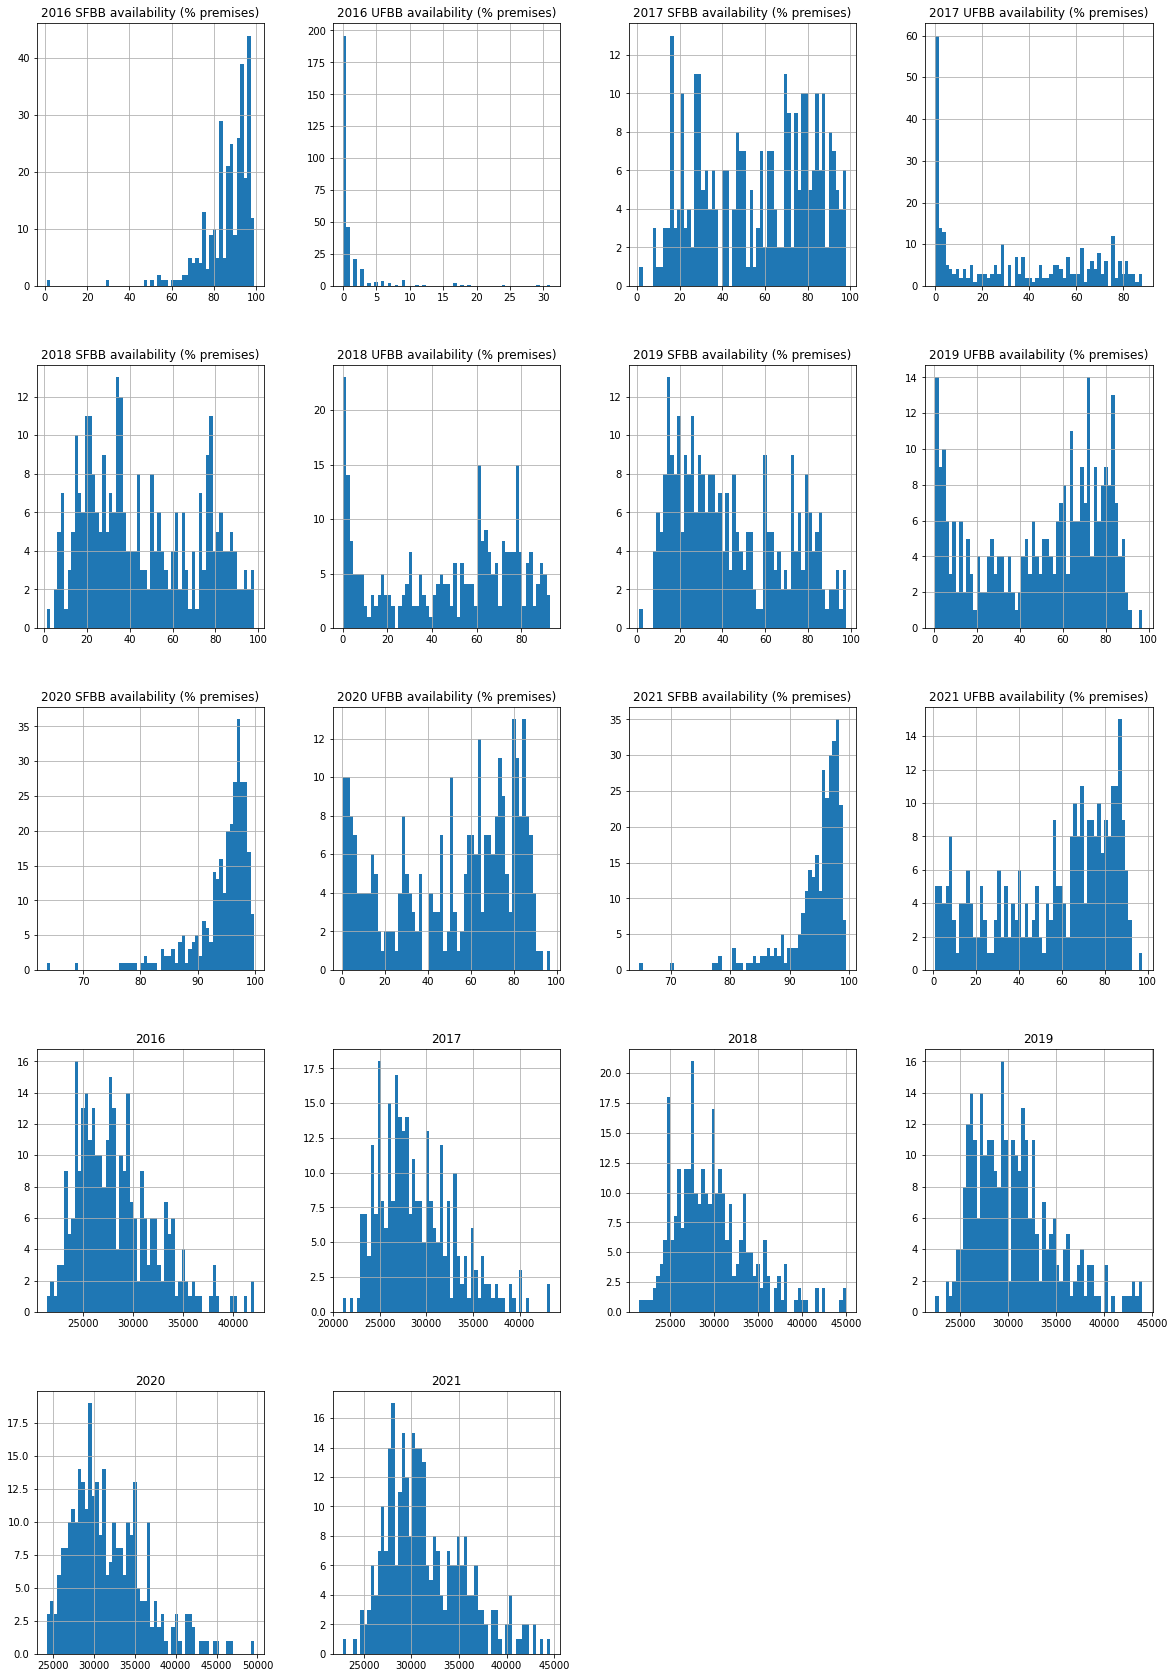

In [55]:
# Histogram to assess distribution of data (wide data)
merged_wide.hist(bins=60, sharex=False, figsize=(20,30))
plt.show()

#### Interpreting the histograms from the wide dataset
In our wide dataset, we get one histogram per year for each variable.

The Income histograms (2016, 2017, 2018, 2019, 2020, 2021) show a close to normal distribution, though they all have a slight positive kurtosis and additional slight positive skew.

We used the UFBB and SFBB histograms to help us determine which of these to proceed the analysis with. Looking at SFBB values in 2016, a lot of areas already have a very high percentage of coverage, while the UFBB dataset shows that in 2016 only a few areas have any coverage and it continuously increases over the years.

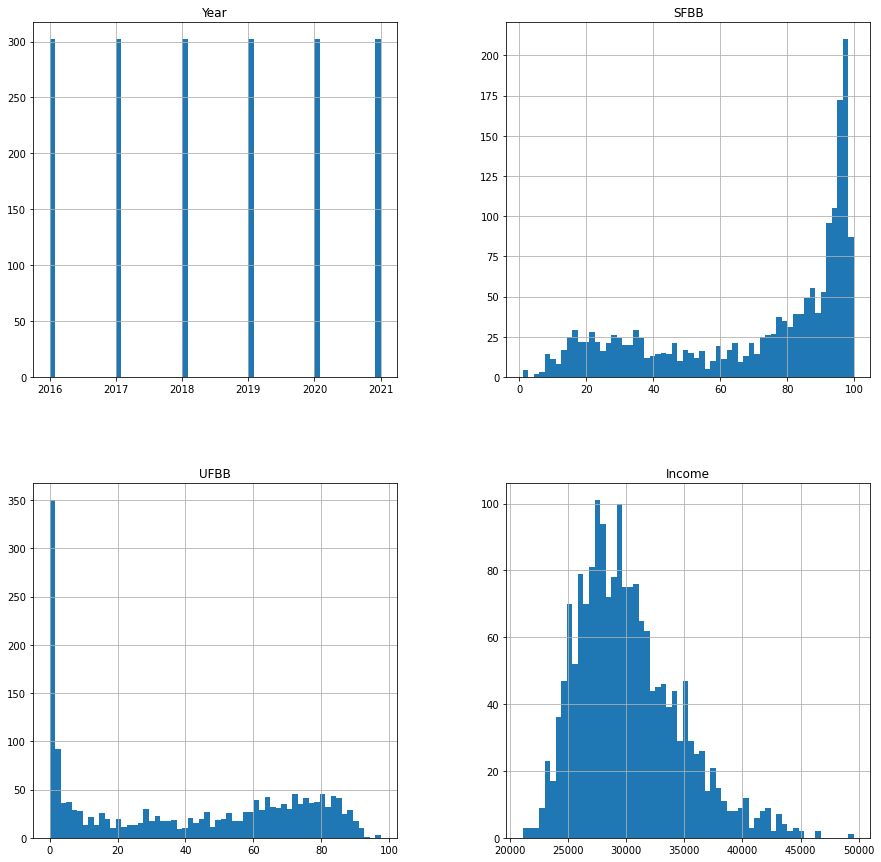

In [56]:
# Histogram to assess distribution of data (long data)
merged_long.hist(bins=60, sharex=False, figsize=(15,15))
plt.show()

#### Interpreting the histograms from the long dataset

These histograms show all the data from 2016-2021 for each variable. 

The income histogram again shows slight positive kurtosis and a postive skew, with some values trailing off towards the higher earning.

Regarding SFBB, the data shows that there are a lot of values of a 100% (or close to). UFBB shows the opposite, there is a spike at 0% and then there is a gradual increase, with no values at 100%. Neither of these variables are normally distributed. After considering this, we decided as a group to use UFBB for our predictive analyses. The reason being that we are looking at the trends over time and trying to see whether income predicts the rollout of internet. Having a 'starting point' close to no coverage is the best way to see, as the SFBB data will not let us determine which areas are prioritised in the rollout.

#### Sorting the values in the long dataset and creating a colour pallete for each region

In [57]:
merged_long = merged_long.sort_values(["Region", "Year"], ascending = (True, True))

In [58]:
# Colour palette to ensure uniformity throughout visualisation
palette = {"East": "#d54b2e",
           "East Midlands": "#5d2000", 
           "London": "#8c4f00", 
           "North East": "#9b8800",
           "North West": "#e0d682",
           "Scotland": "#27cd72",
           "South East": "#009263",
           "South West": "#311658",
           "Wales": "#ff71c8",
           "West Midlands": "#a90072",
           "Yorkshire": "#002162",
          }

#### Creating line plots to investigate the trends of income and  UFBB over time

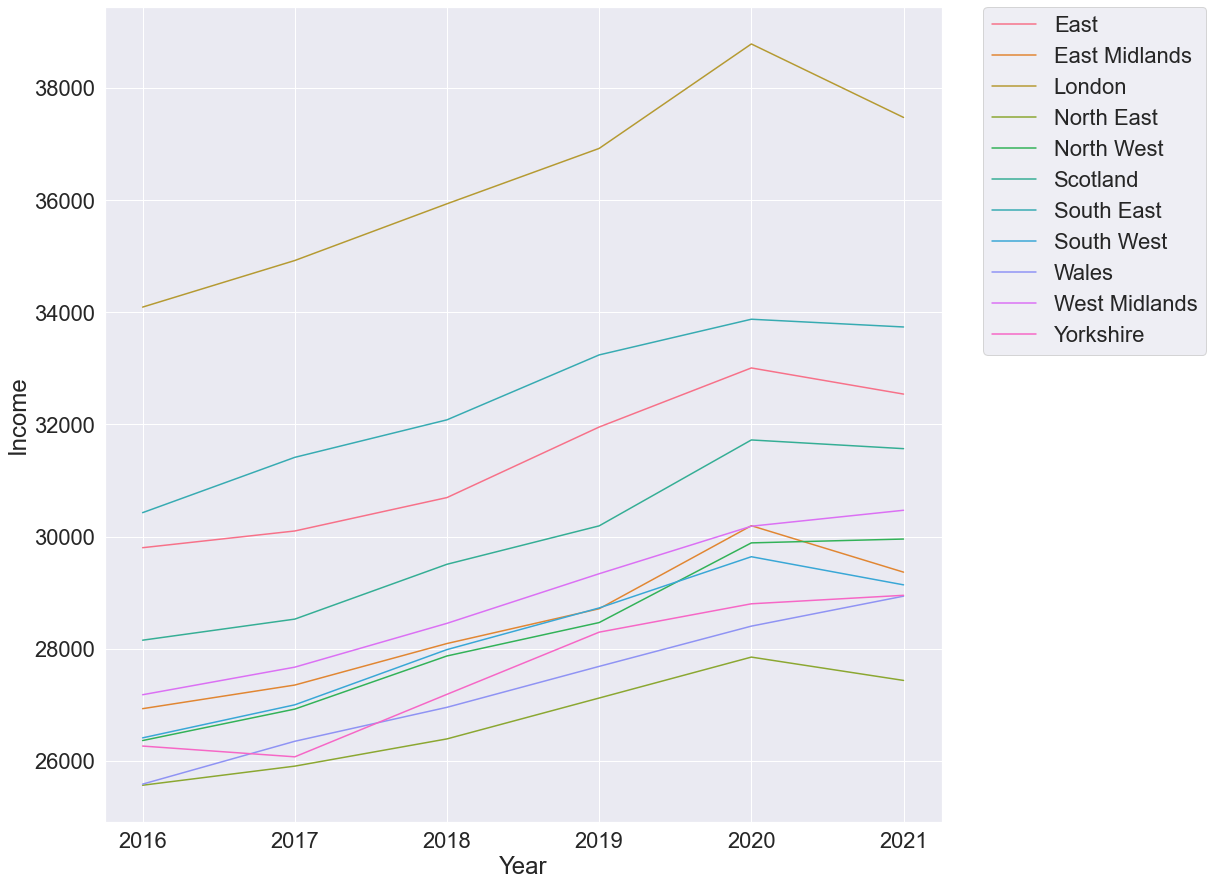

In [59]:
# Line Plot of data Year vs Income
sns.set(rc={'figure.figsize':(15,15)}, font_scale = 2)
sns.lineplot(data=merged_long, x="Year", y="Income", hue = 'Region', ci=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

This lineplot shows that for all regions income has increased over time. Additionally, there is a dip for most regions in 2020. Overall, the order of which region earns the most and least has stayed relatively the same.

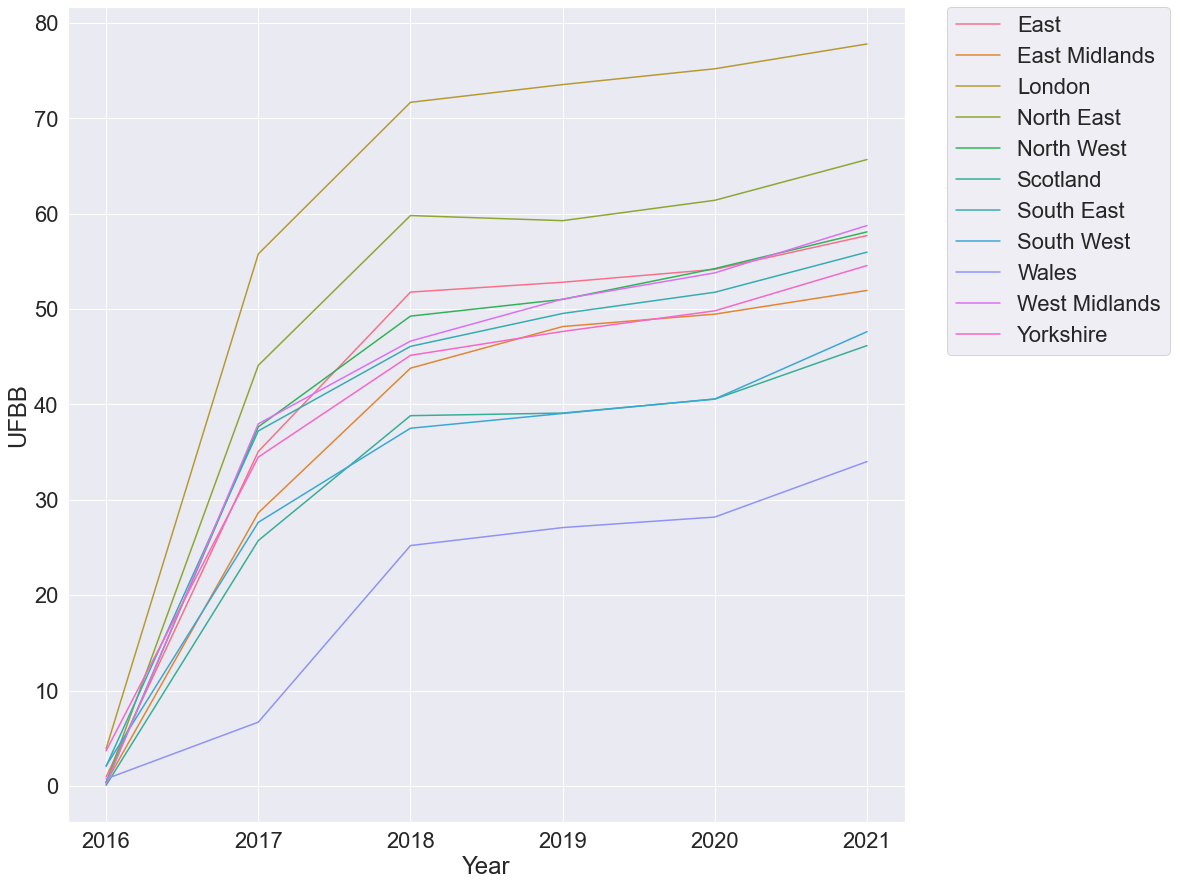

In [60]:
# Line Plot of data Year vs Internet
sns.set(rc={'figure.figsize':(15,15)}, font_scale = 2)
sns.lineplot(data=merged_long, x="Year", y="UFBB", hue = 'Region', ci=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

This lineplot shows that in 2016 most regions had close to 0% UFBB. Most regions had a large increase till 2017 (except for Wales) and then continued to increase more and more gradually. As of 2021, they are still on an upwards trajectory.

#### Investigate whether income can predict the availability of internet visually

In [61]:
merged_long.describe()

,Year,SFBB,UFBB,Income
count,1812.000000,1812.000000,1812.000000,1812.000000
mean,2018.500000,70.327759,40.049945,30190.384658
std,1.708297,28.975955,32.097737,4388.242597
min,2016.000000,1.000000,0.000000,21089.000000
25%,2017.000000,45.175000,3.800000,26980.750000
50%,2018.500000,83.350000,42.100000,29478.500000
75%,2020.000000,95.000000,70.525000,32728.000000
max,2021.000000,99.800000,97.500000,49574.000000


#### Creating a scatterplot for SFBB
The scatterplot for income as a predictor of SFBB over time shows no clear trends. Additionally, the plot shows that there are a lot of areas with a high percentage of SFBB in the first few years already, and by 2021, most areas have SFBB at close to a 100%, no matter the income.

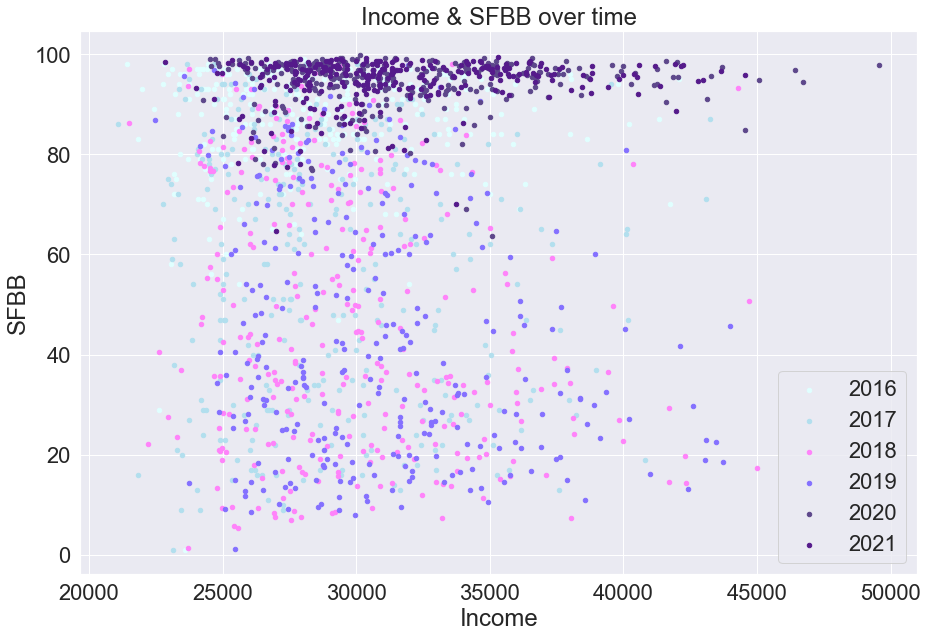

In [62]:
# SFBB plot
fig = merged_long[merged_long.Year==2016].plot(kind='scatter',x='Income',y='SFBB',color='#E0FFFF', label='2016')
merged_long[merged_long.Year==2017].plot(kind='scatter',x='Income',y='SFBB',color='#B2DFEE', label='2017', ax=fig)
merged_long[merged_long.Year==2018].plot(kind='scatter',x='Income',y='SFBB',color='#FF83FA', label='2018', ax=fig)
merged_long[merged_long.Year==2019].plot(kind='scatter',x='Income',y='SFBB',color='#8470FF', label='2019', ax=fig)
merged_long[merged_long.Year==2020].plot(kind='scatter',x='Income',y='SFBB',color='#5D478B', label='2020', ax=fig)
merged_long[merged_long.Year==2021].plot(kind='scatter',x='Income',y='SFBB',color='#551A8B', label='2021', ax=fig)
fig.set_xlabel("Income")
fig.set_ylabel("SFBB")
fig.set_title("Income & SFBB over time")
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show()

#### Creating a scatterplot for UFBB
The scatterplot for income as a predictor of UFBB over time also shows no clear trends. No matter the income, many areas have no UFBB in 2016 and it gradually increases over the years, however, not according to any patternign according to income.

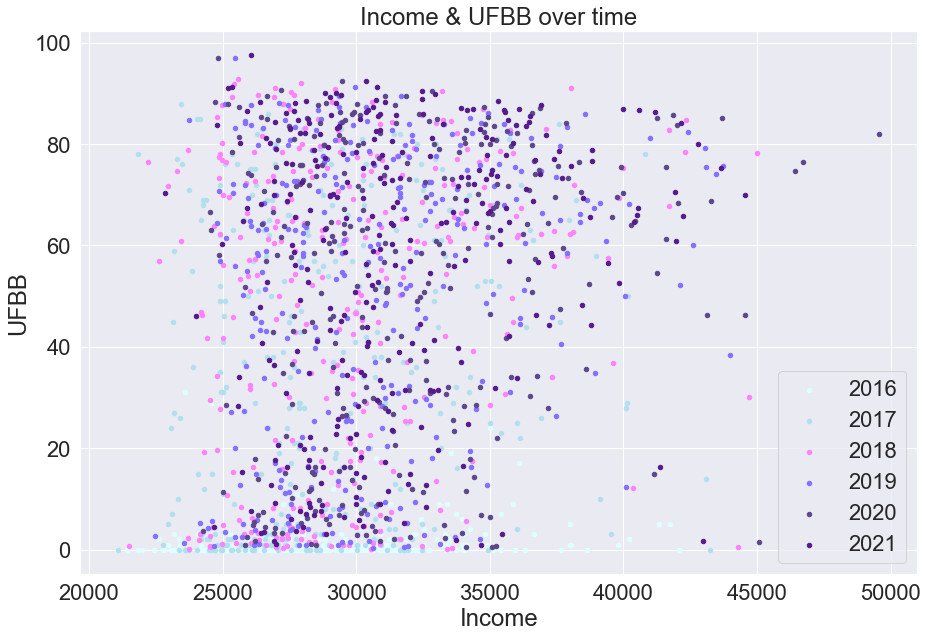

In [63]:
#UFBB Scatter Plot, Sorted by Region
fig = merged_long[merged_long.Year==2016].plot(kind='scatter',x='Income',y='UFBB',color='#E0FFFF', label='2016')
merged_long[merged_long.Year==2017].plot(kind='scatter',x='Income',y='UFBB',color='#B2DFEE', label='2017', ax=fig)
merged_long[merged_long.Year==2018].plot(kind='scatter',x='Income',y='UFBB',color='#FF83FA', label='2018', ax=fig)
merged_long[merged_long.Year==2019].plot(kind='scatter',x='Income',y='UFBB',color='#8470FF', label='2019', ax=fig)
merged_long[merged_long.Year==2020].plot(kind='scatter',x='Income',y='UFBB',color='#5D478B', label='2020', ax=fig)
merged_long[merged_long.Year==2021].plot(kind='scatter',x='Income',y='UFBB',color='#551A8B', label='2021', ax=fig)
fig.set_xlabel("Income")
fig.set_ylabel("UFBB")
fig.set_title("Income & UFBB over time")
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show()

#### Investigating the relationship between income and UFBB availability according to region

We then looked at whether the different regions across the UK showed any evidence for any trends, however, this was not the case. They do show that the datapoints for one area are relatively clustered around similar income levels, which is to be expected, however this is not linked to internet availability.

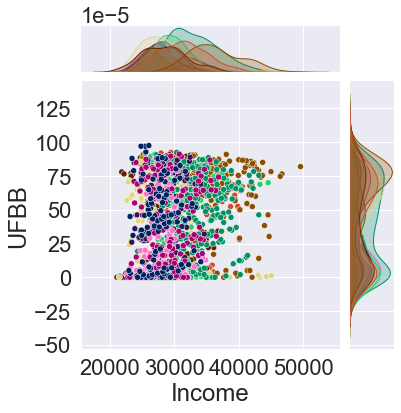

In [64]:
# Joint Plot of Income and UFBB, Sorted by Region
fig = sns.jointplot(x='Income', y= 'UFBB', hue= 'Region', data = merged_long, palette = palette, legend = None)
sns.set(rc = {'figure.figsize':(100,200)})
plt.show()

We also tried to look at the relationship in the form of a joinplot, which confirms the lack of predictive relationship between income and internet. What it does show, however, is that this is linked to the distribution of UFBB, which is largely clustered around 0%.

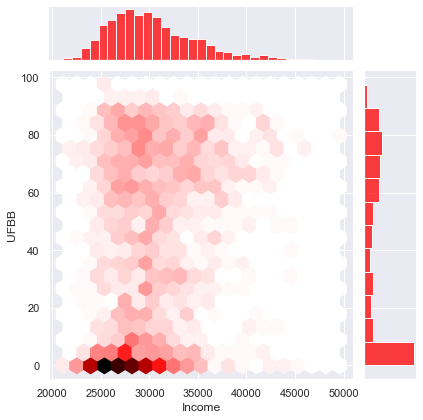

In [65]:
# Joint Plot of Income and UFBB, Sorted by Region
fig = sns.jointplot(x='Income', y= 'UFBB', kind = "hex", data = merged_long, color="red")
sns.set(rc = {'figure.figsize':(100,200)})
plt.show()

We are aware that we have created many different graphs showing the same relationship. This was not in the hopes of finding a significant relationship at some point, but rather to be able to use this as a learning opportunity as well and consider what each different plot shows us about the relationship.

## Step 3, Part 2 - Machine Learning
### Building a Linear Model on the Data
In this section, we will use 80% of data to train the model, and keep 20% of the data for testing. 
This will convey whether our data can be used for predictive analysis

### Note: 
Our scatterplot indicated that our data is clearly not fit for a linear model, but we still made the decision to proceed with this analysis in order to use it as a learning opportunity. Additionally, it is good to have the numeric confirmation for a lack of significant relationship between the two variables.

In [66]:
# Hot encoding the Regions to make them numerical, as required for linear regression
long_data = pd.read_csv("Merged Long Format Data Q3.csv")

long_data.loc[long_data['Region'] == 'East', 'Region'] = 0
long_data.loc[long_data['Region'] == 'East Midlands', 'Region'] = 1
long_data.loc[long_data['Region'] == 'London', 'Region'] = 2
long_data.loc[long_data['Region'] == 'North East', 'Region'] = 3
long_data.loc[long_data['Region'] == 'North West', 'Region'] = 4
long_data.loc[long_data['Region'] == 'Scotland', 'Region'] = 5
long_data.loc[long_data['Region'] == 'South East', 'Region'] = 6
long_data.loc[long_data['Region'] == 'South West', 'Region'] = 7
long_data.loc[long_data['Region'] == 'Wales', 'Region'] = 8
long_data.loc[long_data['Region'] == 'West Midlands', 'Region'] = 9
long_data.loc[long_data['Region'] == 'Yorkshire', 'Region'] = 10

In [67]:
# Hot encoding the Regions to make them numerical, as required for linear regression
wide_data = pd.read_csv("Merged Wide Format Data Q3.csv")

wide_data.loc[wide_data['Region'] == 'East', 'Region'] = 0
wide_data.loc[wide_data['Region'] == 'East Midlands', 'Region'] = 1
wide_data.loc[wide_data['Region'] == 'London', 'Region'] = 2
wide_data.loc[wide_data['Region'] == 'North East', 'Region'] = 3
wide_data.loc[wide_data['Region'] == 'North West', 'Region'] = 4
wide_data.loc[wide_data['Region'] == 'Scotland', 'Region'] = 5
wide_data.loc[wide_data['Region'] == 'South East', 'Region'] = 6
wide_data.loc[wide_data['Region'] == 'South West', 'Region'] = 7
wide_data.loc[wide_data['Region'] == 'Wales', 'Region'] = 8
wide_data.loc[wide_data['Region'] == 'West Midlands', 'Region'] = 9
wide_data.loc[wide_data['Region'] == 'Yorkshire', 'Region'] = 10

In [68]:
# Region variables are still considered string, so they need to be convered to integers
wide_data['Region'] = wide_data['Region'].astype(int)
long_data['Region'] = long_data['Region'].astype(int)

In [69]:
# Testing variables
x = long_data[['Income', 'Region', 'Year']]
y = long_data[['SFBB']]

In [70]:
long_data.describe()

,Year,Region,SFBB,UFBB,Income
count,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000
mean,2018.500000,4.774834,70.327759,40.049945,30190.384658
std,1.708297,3.053737,28.975955,32.097737,4388.242597
min,2016.000000,0.000000,1.000000,0.000000,21089.000000
25%,2017.000000,2.000000,45.175000,3.800000,26980.750000
50%,2018.500000,5.000000,83.350000,42.100000,29478.500000
75%,2020.000000,7.000000,95.000000,70.525000,32728.000000
max,2021.000000,10.000000,99.800000,97.500000,49574.000000


#### TESTING
Testing the data using machine learning
 Step 1: split the data in order to assess model fit
 Step 2: Define the linear model using the scikit function
 Step 3: Define the fit of the model

In [71]:
# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 5)

In [72]:
linearmodel = lr().fit(x_train, y_train)

In [73]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1449, 3)
(363, 3)
(1449, 1)
(363, 1)


In [74]:
# Model testing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Model evaluation for testing set
y_pred = linearmodel.predict(x_test) # using the model we fitted earlier, we get predictions 
mae = mean_absolute_error(y_test, y_pred)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE score is {}'.format(mae)) # can range from 0 to ∞
print('RMSE is {}'.format(rmse)) # can range from 0 to ∞
print('R2 score is {}'.format(r2)) # 0 to 1


The model performance for testing set
--------------------------------------
MAE score is 24.369002527797942
RMSE is 28.26623993775705
R2 score is 0.08640364806111933


In [75]:
# Equation for regression line 
print("Coefficients: \n", linearmodel.coef_)
print("Intercept: \n", linearmodel.intercept_)

Coefficients: 
 [[-4.56758520e-04  2.10906908e-01  4.48046242e+00]]
Intercept: 
 [-8960.83606318]


#### Interpretation of our model fit

In simple terms, we have a very bad model fit, which is to be excpected after the scatterplot.

Both our MAE and RMSE show that the average magnitudes of errors in our model are very high. Additionally, the amount of variation explained by our model (R2) is only 8%, so much lower than a good model fit.

#### Intercept
Another indicator for a bad model fit is that our model would have an intercept of -8960.84, however, the variable used  (UFBB) is on a scale of 0-100. 

#### Calculating correlations between our variables

#### First we ran a correlation on our long dataset.
We used a correlation matrix to investigate the relationships between our predicting variable (Income) and our outcome variables (UFBB and SFBB). The results showed that non of the relationships were significant. Year and Region should be disregarded in this context as year is an ordinal variable and Region is categorical and therefore no correlation can be assumed.

#### Second we ran a correlation on our wide dataset.
In our wide dataset, we can see the correlation for each of the variables with each other, but also the same variable at different time points. The results show that as predicted, the previous years values of UFBB and SFBB will be correlated with the following years values. Again, income is not significantly correlated with internet, not even in just one of the years.



<AxesSubplot:>

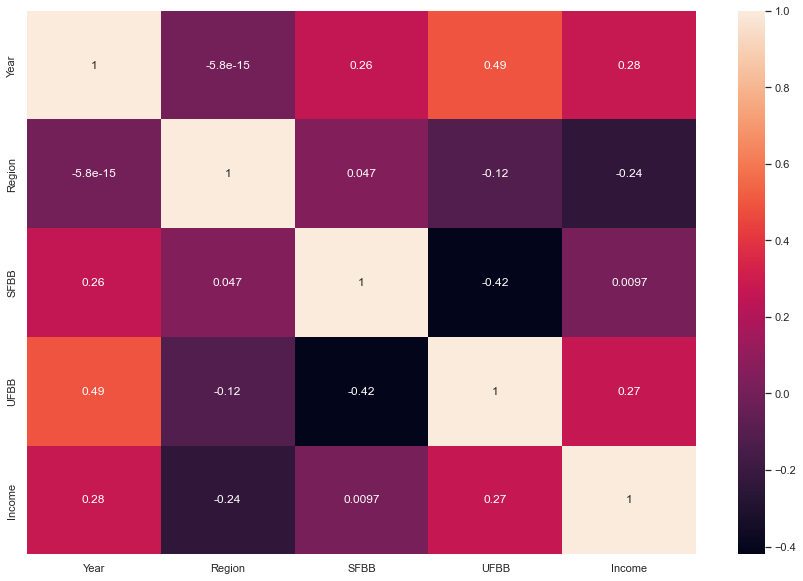

In [76]:
# Correlation Matrix - to show correlations between variables, + 0.7 and above or -0.7 and below expresses a good correlation
plt.figure(figsize = (15,10))
correlation_matrix = long_data.corr() # returns a df

# Seaborn adds heatmap to visually highlight significant values in the matrix
sns.heatmap(data = correlation_matrix, annot = True) 

<AxesSubplot:>

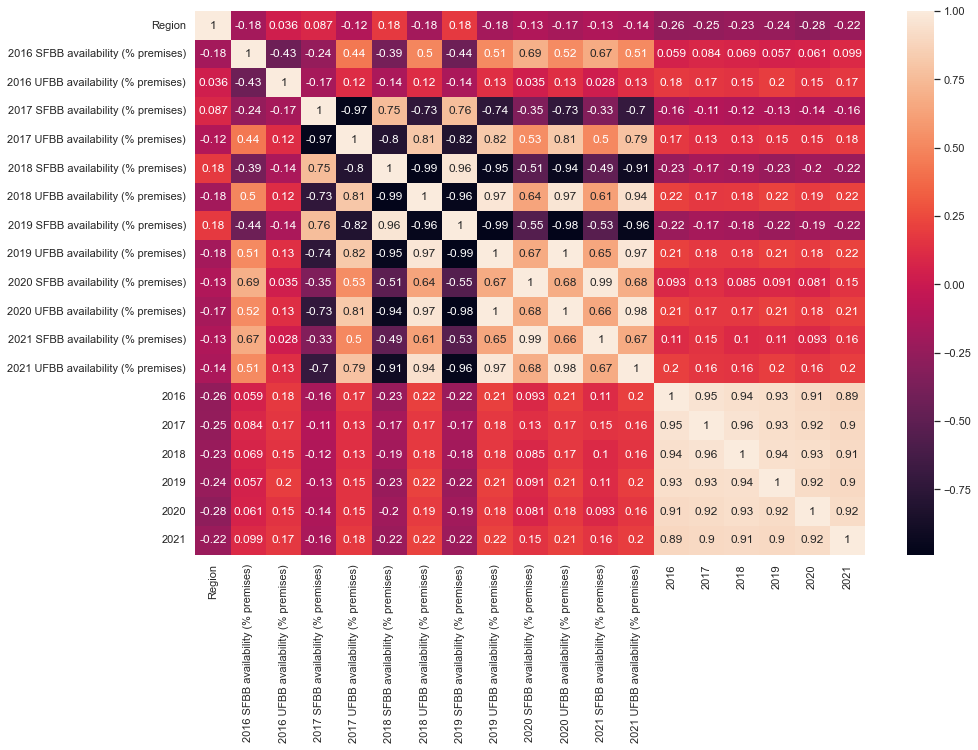

In [77]:
# Correlation Matrix - to show correlations between variables, + 0.7 and above or -0.7 and below expresses a good correlation
plt.figure(figsize = (15,10))
correlation_matrix2 = wide_data.corr() # returns a df

# seaborn adds heatmap to visually highlight significant values in the matrix
sns.heatmap(data = correlation_matrix2, annot = True) 

#### Searching for Outliers
The below shows the anomalies in the data variables.

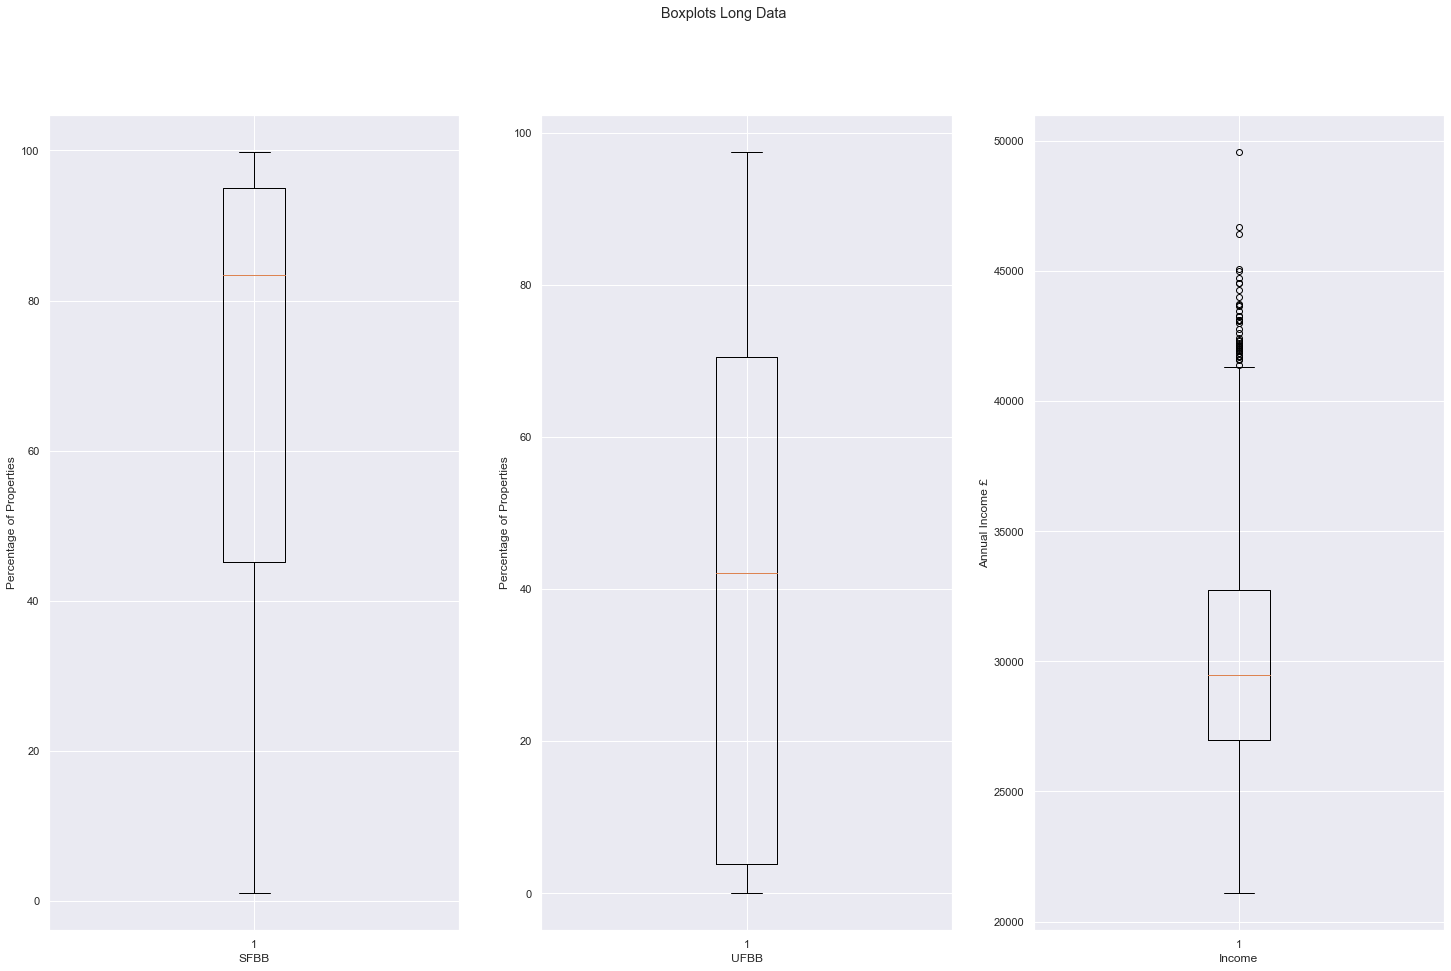

In [78]:
# Box Plots
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,15))
fig.suptitle('Boxplots Long Data')

ax1.boxplot('SFBB', data = long_data)
ax1.set_xlabel("SFBB")
ax1.set_ylabel("Percentage of Properties")

ax2.boxplot('UFBB', data = long_data)
ax2.set_xlabel("UFBB")
ax2.set_ylabel("Percentage of Properties")

ax3.boxplot('Income', data = long_data)
ax3.set_xlabel("Income")
ax3.set_ylabel("Annual Income £")
plt.show()

#### Split into regions
The below is splitting the data into different groups for plotting.

In [79]:
grouped = long_data.groupby(long_data.Region)
east = grouped.get_group(0)
eastmid = grouped.get_group(1)
ldn = grouped.get_group(2)
neast= grouped.get_group(3)
nwest = grouped.get_group(4)
scotland = grouped.get_group(5)
seast = grouped.get_group(6)
swest = grouped.get_group(7)
wales = grouped.get_group(8)
westmid = grouped.get_group(9)
yorkshire = grouped.get_group(10)

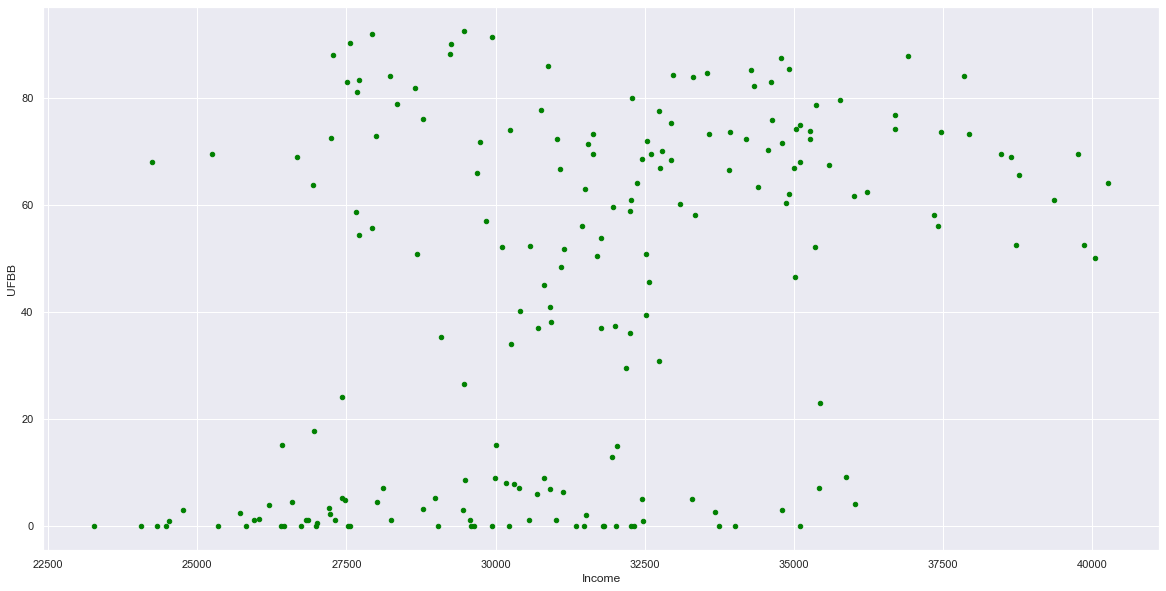

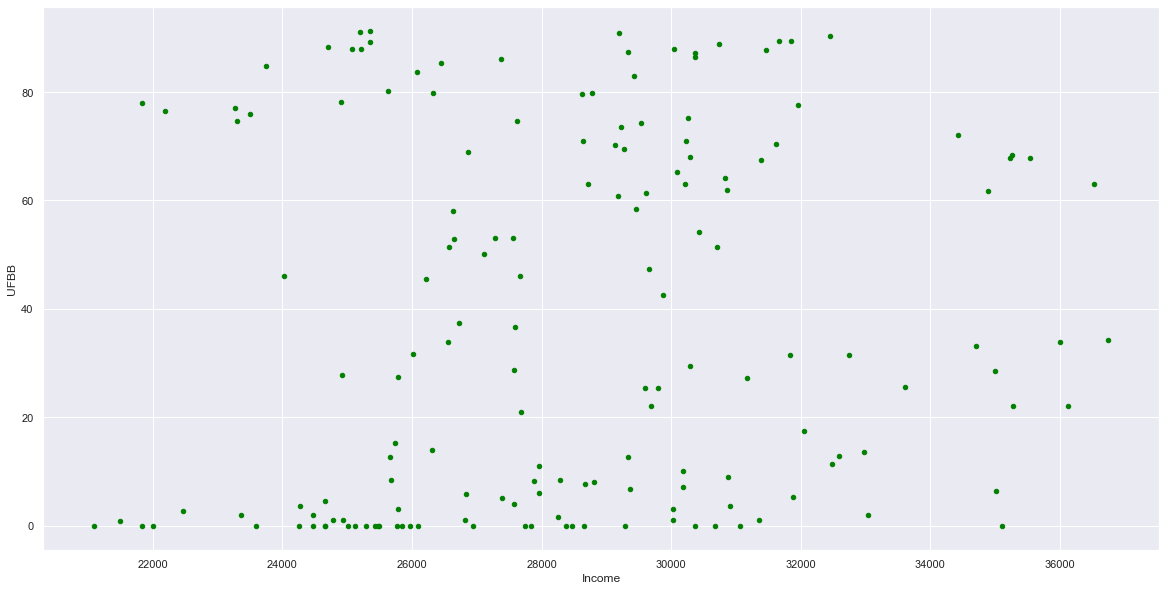

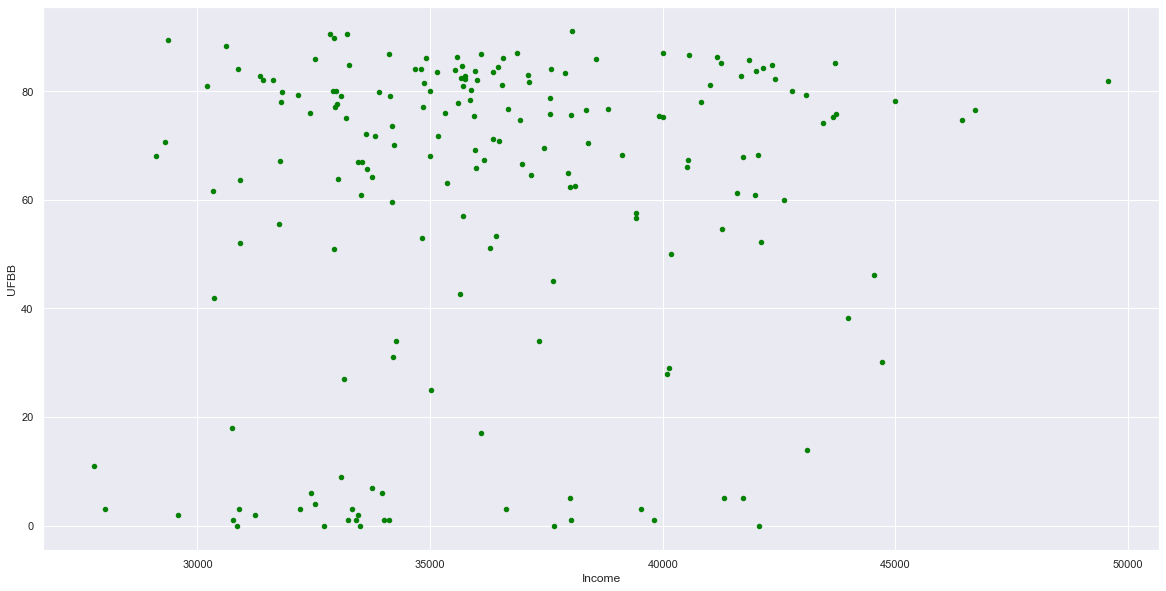

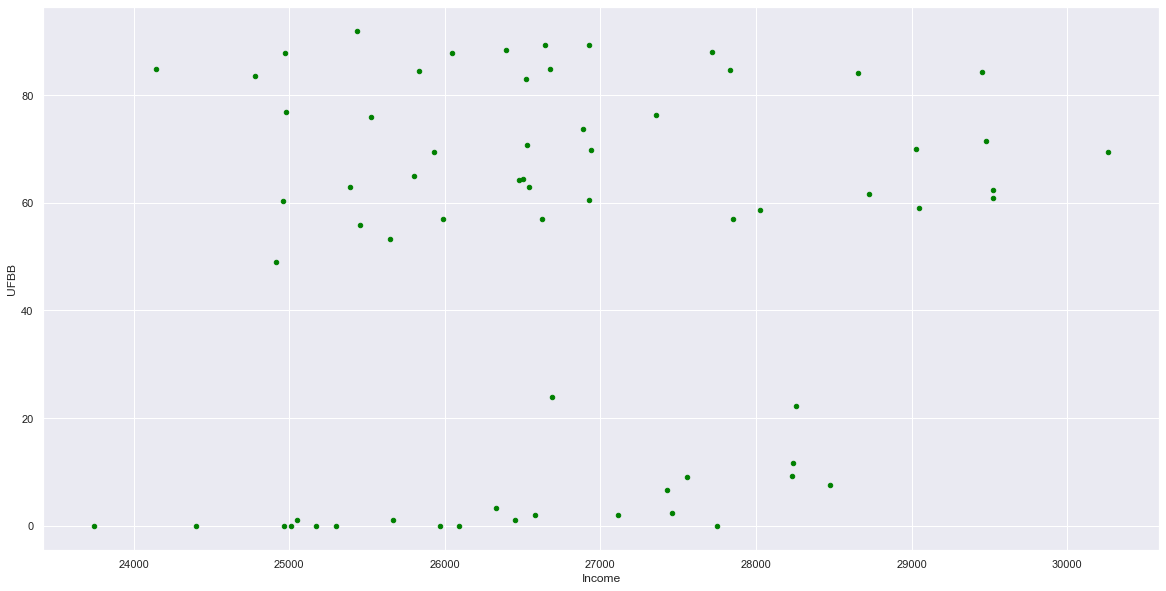

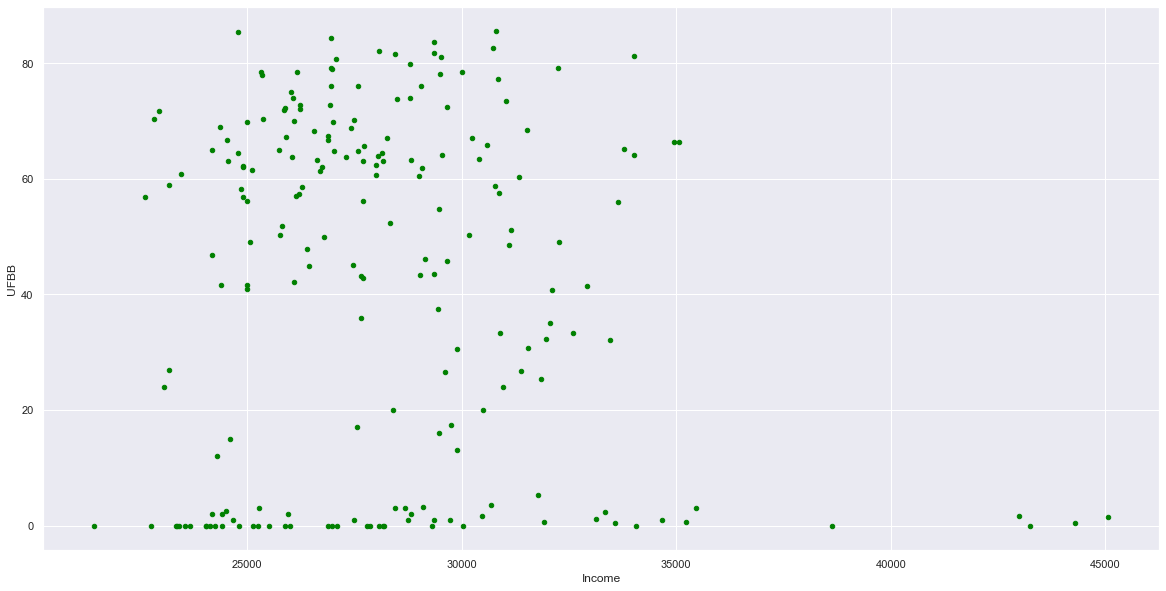

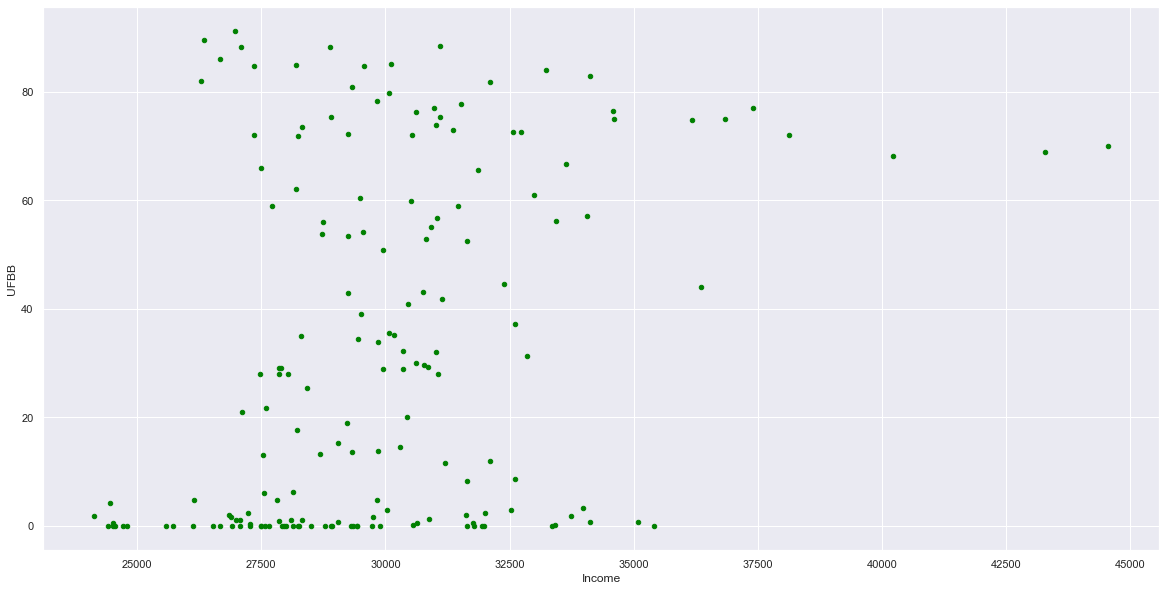

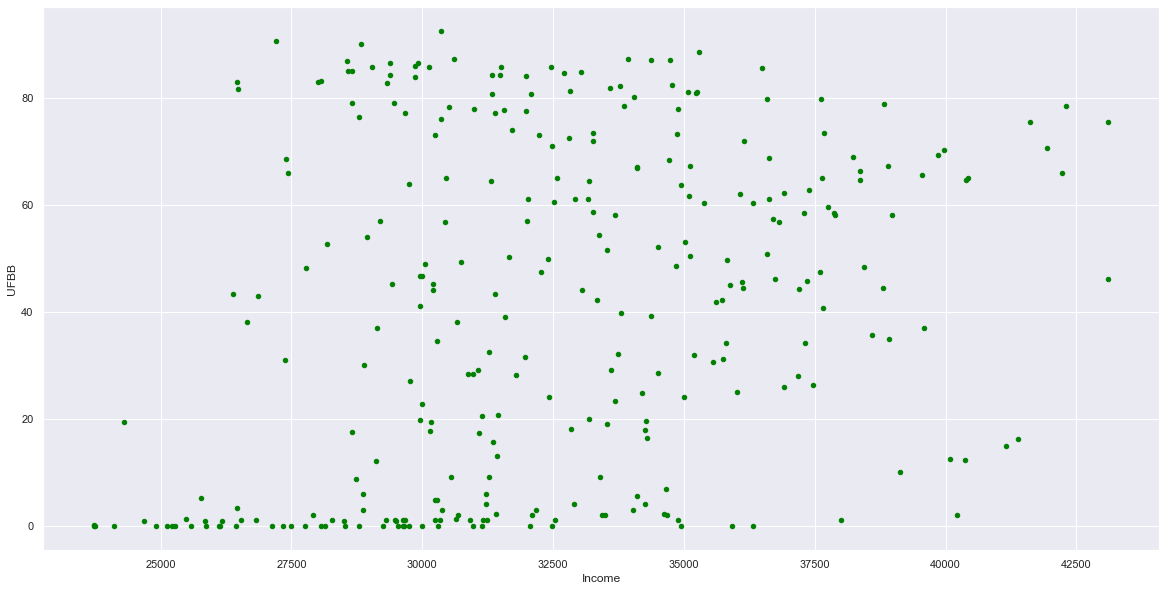

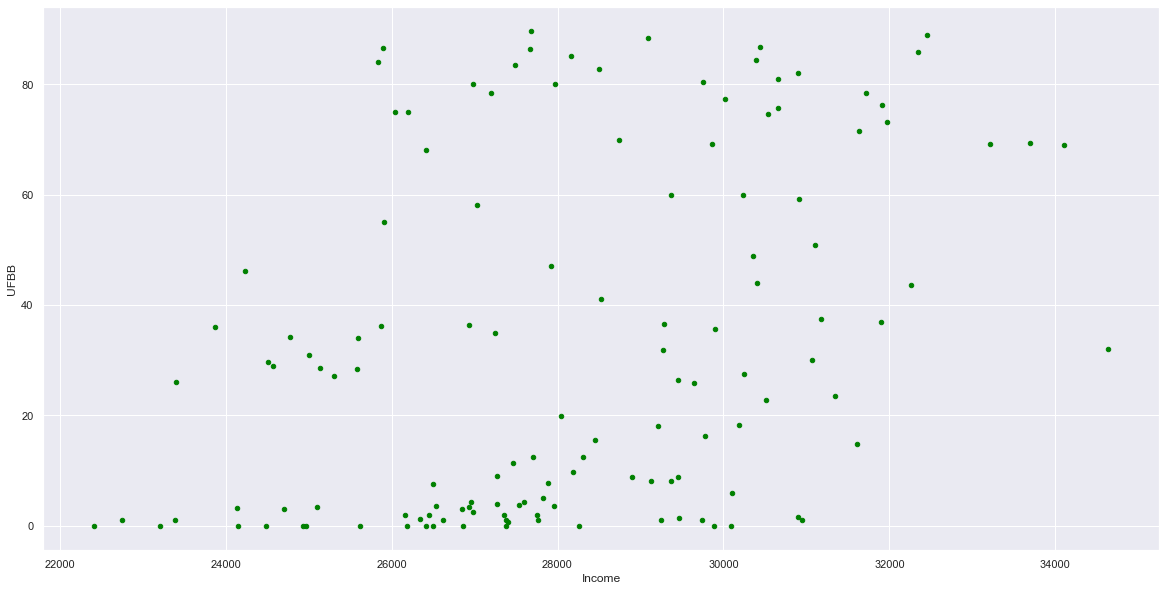

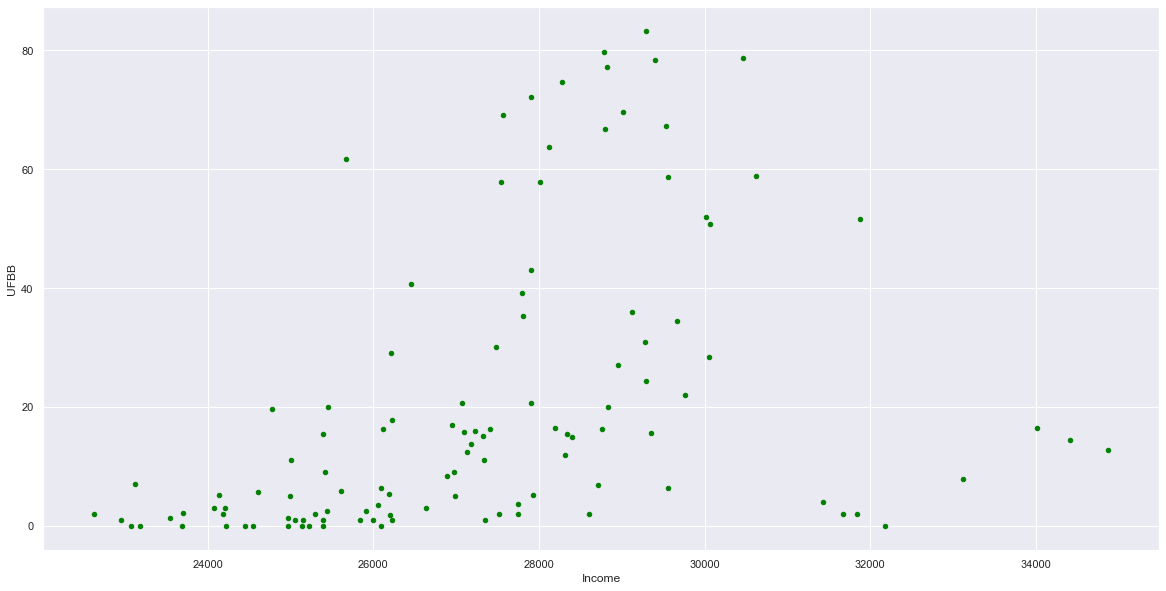

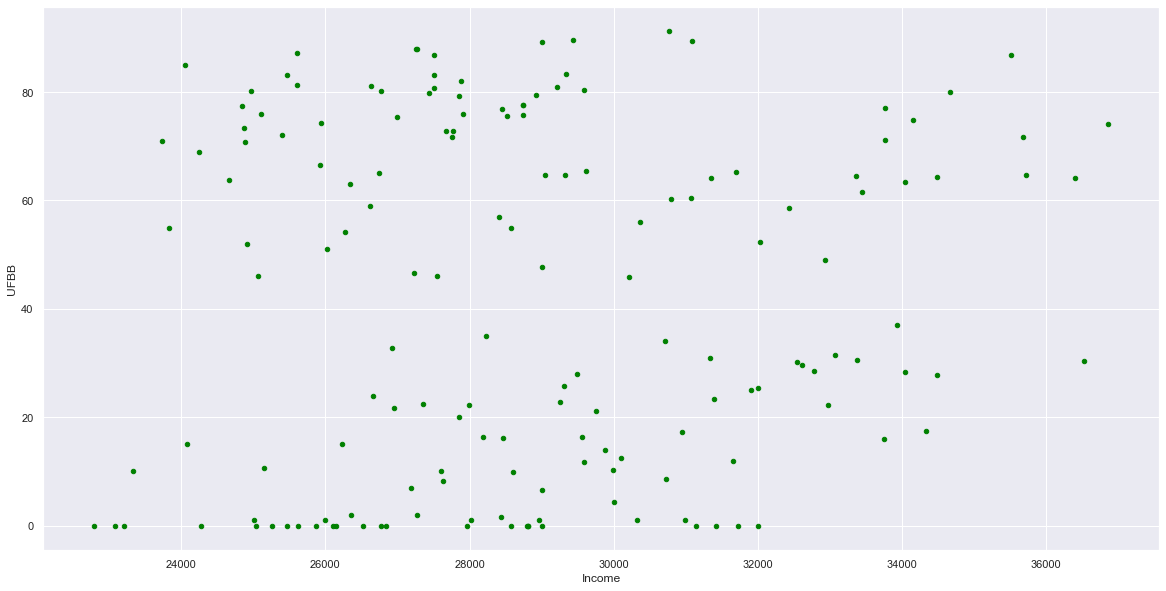

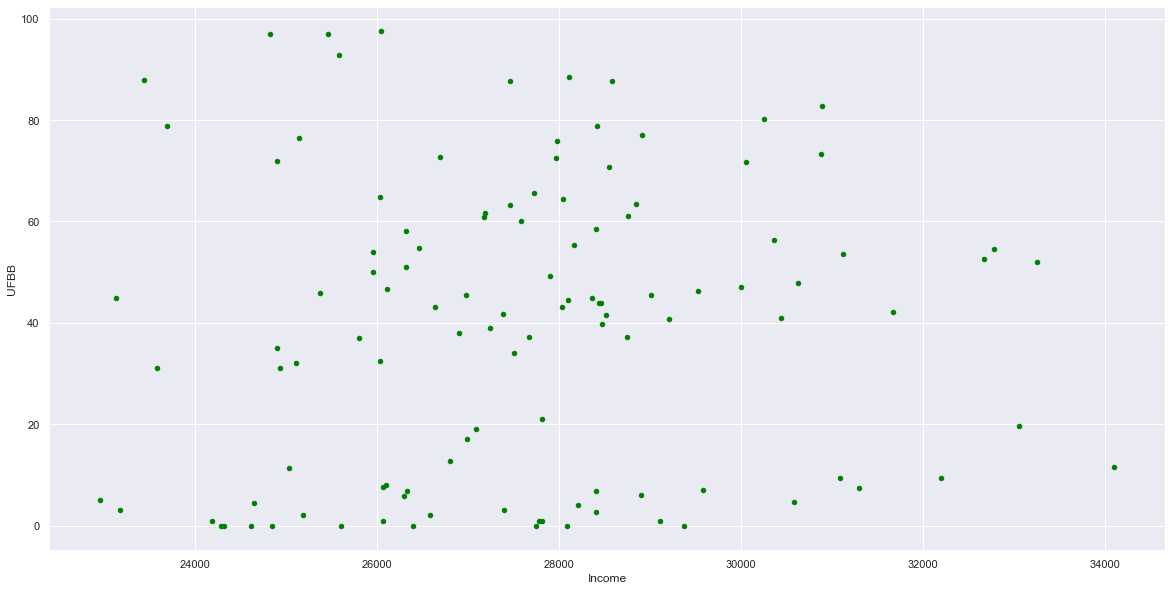

In [109]:
# Income and UFBB for each region. cant do year, because it's ordinal and not continuous
# If any had come back significant, we would have explored it further and created it's own plot
plt.rcParams["figure.figsize"] = (20,10)
long_data.groupby(['Region']).plot(kind='scatter', x='Income', y='UFBB', legend=True, subplots=True, color='green', marker = 'o')
plt.show()

### Testing Linear Models for Each Region

We tested linear models for each individual region to see whether income predicted UFBB rollout over time. As with our linearmodel above, this was not the case for any individual region.

The model fit was bad for all of the models again.

In [ ]:
# East Group
eastx = east[['Income', 'Year']]
easty = east[['UFBB']]
# Split into train and test data
eastx_train, eastx_test, easty_train, easty_test = train_test_split(eastx, easty, test_size = 0.2, random_state = 5)
linearmodeleast = lr().fit(eastx_train, easty_train) 

# model evaluation for testing set
easty_pred = linearmodeleast.predict(eastx_test) # using the model we fitted earlier, we get predictions 

maeeast = mean_absolute_error(easty_test, easty_pred)
rmseeast = (np.sqrt(mean_squared_error(easty_test, easty_pred)))
r2east = r2_score(easty_test, easty_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE score is {}'.format(maeeast)) # can range from 0 to ∞
print('RMSE is {}'.format(rmseeast)) # can range from 0 to ∞
print('R2 score is {}'.format(r2east)) # 0 to 1

The model performance for testing set
--------------------------------------
MAE score is 22.74504593217647
RMSE is 28.300068756131473
R2 score is 0.2927605235483969


In [ ]:
# East Midlands Group
x2 = eastmid[['Income', 'Year']]
y2 = eastmid[['UFBB']]
# Split into train and test data
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2, random_state = 5)
linearmodel2 = lr().fit(x2_train, y2_train) 

# model evaluation for testing set
y2_pred = linearmodel2.predict(x2_test) # using the model we fitted earlier, we get predictions 

mae2 = mean_absolute_error(y2_test, y2_pred)
rmse2 = (np.sqrt(mean_squared_error(y2_test, y2_pred)))
r22 = r2_score(y2_test, y2_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE score is {}'.format(mae2)) # can range from 0 to ∞
print('RMSE is {}'.format(rmse2)) # can range from 0 to ∞
print('R2 score is {}'.format(r22)) # 0 to 1

The model performance for testing set
--------------------------------------
MAE score is 21.628957861228905
RMSE is 25.773673070081745
R2 score is 0.18430834186545653


In [ ]:
# London Group
x3 = ldn[['Income', 'Year']]
y3 = ldn[['UFBB']]
# Split into train and test data
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size = 0.2, random_state = 5)
linearmodel3 = lr().fit(x3_train, y3_train) 

# model evaluation for testing set
y3_pred = linearmodel3.predict(x3_test) # using the model we fitted earlier, we get predictions 

mae3 = mean_absolute_error(y3_test, y3_pred)
rmse3 = (np.sqrt(mean_squared_error(y3_test, y3_pred)))
r23 = r2_score(y3_test, y3_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE score is {}'.format(mae3)) # can range from 0 to ∞
print('RMSE is {}'.format(rmse3)) # can range from 0 to ∞
print('R2 score is {}'.format(r23)) # 0 to 1

The model performance for testing set
--------------------------------------
MAE score is 17.68066825571114
RMSE is 20.36107032062608
R2 score is 0.5536956285331452


In [ ]:
# North East Group
x4 = neast[['Income', 'Year']]
y4 = neast[['UFBB']]
# Split into train and test data
x4_train, x4_test, y4_train, y4_test = train_test_split(x4, y4, test_size = 0.2, random_state = 5)
linearmodel4 = lr().fit(x4_train, y4_train) 

# model evaluation for testing set
y4_pred = linearmodel4.predict(x4_test) # using the model we fitted earlier, we get predictions 

mae4 = mean_absolute_error(y4_test, y4_pred)
rmse4 = (np.sqrt(mean_squared_error(y4_test, y4_pred)))
r24 = r2_score(y4_test, y4_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE score is {}'.format(mae4)) # can range from 0 to ∞
print('RMSE is {}'.format(rmse4)) # can range from 0 to ∞
print('R2 score is {}'.format(r24)) # 0 to 1

The model performance for testing set
--------------------------------------
MAE score is 22.570231318825087
RMSE is 26.00273713174487
R2 score is 0.30556671406919556


In [ ]:
# Scotland Group
x5 = scotland[['Income', 'Year']]
y5 = scotland[['UFBB']]
# Split into train and test data
x5_train, x5_test, y5_train, y5_test = train_test_split(x5, y5, test_size = 0.2, random_state = 5)
linearmodel5 = lr().fit(x5_train, y5_train) 

# model evaluation for testing set
y5_pred = linearmodel5.predict(x5_test) # using the model we fitted earlier, we get predictions 

mae5 = mean_absolute_error(y5_test, y5_pred)
rmse5 = (np.sqrt(mean_squared_error(y5_test, y5_pred)))
r25 = r2_score(y5_test, y5_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE score is {}'.format(mae5)) # can range from 0 to ∞
print('RMSE is {}'.format(rmse5)) # can range from 0 to ∞
print('R2 score is {}'.format(r25)) # 0 to 1

The model performance for testing set
--------------------------------------
MAE score is 24.747160424660905
RMSE is 29.25164716112884
R2 score is 0.2936399381611089


In [ ]:
# South East Group
x6 = seast[['Income', 'Year']]
y6 = seast[['UFBB']]
# Split into train and test data
x6_train, x6_test, y6_train, y6_test = train_test_split(x6, y6, test_size = 0.2, random_state = 5)
linearmodel6 = lr().fit(x6_train, y6_train) 

# model evaluation for testing set
y6_pred = linearmodel6.predict(x6_test) # using the model we fitted earlier, we get predictions 

mae6 = mean_absolute_error(y6_test, y6_pred)
rmse6 = (np.sqrt(mean_squared_error(y6_test, y6_pred)))
r26 = r2_score(y6_test, y6_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE score is {}'.format(mae6)) # can range from 0 to ∞
print('RMSE is {}'.format(rmse6)) # can range from 0 to ∞
print('R2 score is {}'.format(r26)) # 0 to 1

The model performance for testing set
--------------------------------------
MAE score is 21.101084353787083
RMSE is 25.00021581445065
R2 score is 0.28286677517051684


In [ ]:
# South West Group
x7 = swest[['Income', 'Year']]
y7 = swest[['UFBB']]
# Split into train and test data
x7_train, x7_test, y7_train, y7_test = train_test_split(x7, y7, test_size = 0.2, random_state = 5)
linearmodel7 = lr().fit(x7_train, y7_train) 

# model evaluation for testing set
y7_pred = linearmodel7.predict(x7_test) # using the model we fitted earlier, we get predictions 

mae7 = mean_absolute_error(y7_test, y7_pred)
rmse7 = (np.sqrt(mean_squared_error(y7_test, y7_pred)))
r27 = r2_score(y7_test, y7_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE score is {}'.format(mae7)) # can range from 0 to ∞
print('RMSE is {}'.format(rmse7)) # can range from 0 to ∞
print('R2 score is {}'.format(r27)) # 0 to 1

The model performance for testing set
--------------------------------------
MAE score is 19.174608561286586
RMSE is 22.840909204991522
R2 score is 0.4173056278192888


In [ ]:
# Wales Group
x8 = wales[['Income', 'Year']]
y8 = wales[['UFBB']]
# Split into train and test data
x8_train, x8_test, y8_train, y8_test = train_test_split(x8, y8, test_size = 0.2, random_state = 5)
linearmodel8 = lr().fit(x8_train, y8_train) 

# model evaluation for testing set
y8_pred = linearmodel8.predict(x8_test) # using the model we fitted earlier, we get predictions 

mae8 = mean_absolute_error(y8_test, y8_pred)
rmse8 = (np.sqrt(mean_squared_error(y8_test, y8_pred)))
r28 = r2_score(y8_test, y8_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE score is {}'.format(mae8)) # can range from 0 to ∞
print('RMSE is {}'.format(rmse8)) # can range from 0 to ∞
print('R2 score is {}'.format(r28)) # 0 to 1

The model performance for testing set
--------------------------------------
MAE score is 18.02690729999649
RMSE is 22.972506654288054
R2 score is 0.2984052248747989


In [ ]:
# West Midlands Group
x9 = westmid[['Income', 'Year']]
y9 = westmid[['UFBB']]
# Split into train and test data
x9_train, x9_test, y9_train, y9_test = train_test_split(x9, y9, test_size = 0.2, random_state = 5)
linearmodel9 = lr().fit(x9_train, y9_train) 

# model evaluation for testing set
y9_pred = linearmodel9.predict(x9_test) # using the model we fitted earlier, we get predictions 

mae9 = mean_absolute_error(y9_test, y9_pred)
rmse9 = (np.sqrt(mean_squared_error(y9_test, y9_pred)))
r29 = r2_score(y9_test, y9_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE score is {}'.format(mae9)) # can range from 0 to ∞
print('RMSE is {}'.format(rmse9)) # can range from 0 to ∞
print('R2 score is {}'.format(r29)) # 0 to 1

The model performance for testing set
--------------------------------------
MAE score is 25.044754604118037
RMSE is 28.129293665764674
R2 score is 0.27524101234964127


In [ ]:
# Yorkshire Group
x10 = yorkshire[['Income', 'Year']]
y10 = yorkshire[['UFBB']]
# Split into train and test data
x10_train, x10_test, y10_train, y10_test = train_test_split(x10, y10, test_size = 0.2, random_state = 5)
linearmodel10 = lr().fit(x10_train, y10_train) 

# model evaluation for testing set
y10_pred = linearmodel10.predict(x10_test) # using the model we fitted earlier, we get predictions 

mae10 = mean_absolute_error(y10_test, y10_pred)
rmse10 = (np.sqrt(mean_squared_error(y10_test, y10_pred)))
r210 = r2_score(y10_test, y10_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE score is {}'.format(mae10)) # can range from 0 to ∞
print('RMSE is {}'.format(rmse10)) # can range from 0 to ∞
print('R2 score is {}'.format(r210)) # 0 to 1

The model performance for testing set
--------------------------------------
MAE score is 22.469529806437702
RMSE is 26.785847477293814
R2 score is 0.0754252772250732


# Question 3 - What is the nature of the relationship between internet infrastructure and income at this moment in time?

#### Note: 
Data is not available for the whole of 2021, information is reflecting half the year. Therefore an analysis after 2021 could show better results when completing the analysis.

## Step 1 Loading Data - Ofcom Broadband Data 
This section of code loads the required data from files and creates dataframes limited to the relevant columns we will be using. 

Dataset for 2021 Broadband data for SuperFast Broadband, Ultra Fast Broadband, and Full Fibre Broadbandand download speeds in those areas.

In [ ]:
# Dataset 2021 for Question 3
Twenty1 = pd.read_csv('2021_data.csv')

#     Select specific columns needed: 
#     local authority name, 
#     % of premises that can receive Superfast broadband, 
#     % of premises that can receive ultrafast broadband,
#     % of premises that can receive full fibre,


Q32021 = Twenty1[['laua_name',
              'SFBB availability (% premises)',
              'UFBB availability (% premises)',
            'Full Fibre availability (% premises)',            
        ]]

# Rename variables
cleanQ32021 = Q32021.rename({'laua_name': 'Area',
                        'SFBB availability (% premises)': '2021 SFBB availability (% premises)',
                        'UFBB availability (% premises)': '2021 UFBB availability (% premises)',
                        'Full Fibre availability (% premises)':'2021 FFBB availability (% premises)'}, axis='columns')

# Capitalize area string
cleanQ32021['Area']=cleanQ32021['Area'].str.upper()
#cleanQ32021  # viewing data

Datasets used were adopted from merged data in Q2. Since, only the current years dataset is required, we selected the 2021 column for visualisation and renamed it data_21.

In [ ]:
# Merging Ofcom Broadband 2021 dataset 
# and merged income data set into a wide data format

merged_Q3 = pd.merge(cleanQ32021,income, on = "Area")



data_21 = merged_Q3[['Region',
                     'Area',
                       '2021 SFBB availability (% premises)',
                '2021 UFBB availability (% premises)',
                  '2021 FFBB availability (% premises)',
                    2021]]
data_21

,Region,Area,2021 SFBB availability (% premises),2021 UFBB availability (% premises),2021 FFBB availability (% premises),2021
0,Scotland,ABERDEEN CITY,94.3,50.8,45.8,29949.0
1,Scotland,ABERDEENSHIRE,82.8,8.5,8.4,32605.0
2,South East,ADUR,98.8,85.4,0.7,NaN
3,North West,ALLERDALE,92.5,3.1,3.1,35461.0
4,East Midlands,AMBER VALLEY,95.3,27.3,24.2,31174.0
...,...,...,...,...,...,...
353,Wales,WREXHAM,94.1,39.1,38.8,27793.0
354,West Midlands,WYCHAVON,93.8,16.3,9.1,28189.0
355,North West,WYRE,94.7,29.0,28.6,29379.0
356,West Midlands,WYRE FOREST,96.6,47.7,2.1,29010.0


The column 2021 was renamed to income to allow for clarity when plotting the graphs

## Step 2 - Cleaning Data
In this section, the data will be cleaned to remove the 2021 null values.

In [ ]:
# Renaming the columns to Income for continuity
data_21 =data_21.rename(columns={2021: "Income"})
data_21 = data_21.dropna()
# data_21

## Step 3 - Analysis & Visualisation 
In this section we investigate the merged datasets in order to identify disparities between internet infrastructure and income of different regions.

#### Creating a scatterplot for SFBB

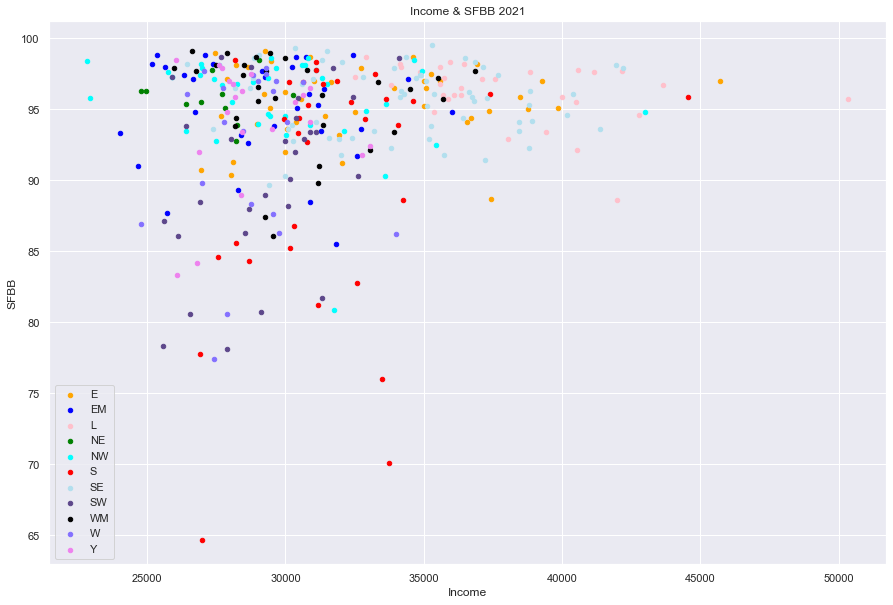

In [ ]:
#SFBB plot for 2021
fig = data_21[data_21.Region=='East'].plot(kind='scatter',x='Income',y='2021 SFBB availability (% premises)',color='orange', label='E')
data_21[data_21.Region=='East Midlands'].plot(kind='scatter',x='Income',y='2021 SFBB availability (% premises)',color='blue', label='EM', ax=fig)
data_21[data_21.Region=='London'].plot(kind='scatter',x='Income',y='2021 SFBB availability (% premises)',color='pink', label='L', ax=fig)
data_21[data_21.Region=='North East'].plot(kind='scatter',x='Income',y='2021 SFBB availability (% premises)',color='green', label='NE', ax=fig)
data_21[data_21.Region=='North West'].plot(kind='scatter',x='Income',y='2021 SFBB availability (% premises)',color='cyan', label='NW', ax=fig)
data_21[data_21.Region=='Scotland'].plot(kind='scatter',x='Income',y='2021 SFBB availability (% premises)',color='red', label='S', ax=fig)
data_21[data_21.Region=='South East'].plot(kind='scatter',x='Income',y='2021 SFBB availability (% premises)',color='#B2DFEE', label='SE', ax=fig)
data_21[data_21.Region=='South West'].plot(kind='scatter',x='Income',y='2021 SFBB availability (% premises)',color='#5D478B', label='SW', ax=fig)
data_21[data_21.Region=='West Midlands'].plot(kind='scatter',x='Income',y='2021 SFBB availability (% premises)',color='black', label='WM', ax=fig)
data_21[data_21.Region=='Wales'].plot(kind='scatter',x='Income',y='2021 SFBB availability (% premises)',color='#8470FF', label='W', ax=fig)
data_21[data_21.Region=='Yorkshire'].plot(kind='scatter',x='Income',y='2021 SFBB availability (% premises)',color='violet', label='Y', ax=fig)
fig.set_xlabel("Income")
fig.set_ylabel("SFBB")
fig.set_title("Income & SFBB 2021")
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show()

#### Depicting individual relationships in the SFBB plot

East: No Relatiosnship, has an outlier

East Midlands: Moderate, positive non linear 

London: No Relatiosnship 

North East: Almost straight flat line. (Income has no bearing on internet availability) 

Scotland: Positive Non linear 

North West: Almost straight flat line 

South East: Almost straight flat line

South West: Random, No relationship 

West Midlands: Almost straight flat line, few outliers 

Wales: Random 

Yorkshire: Random

Positive Linear: As X increases, Y increases 

Negative Linear: As X increases, Y decreases 

Non Linear: Curved pattern, the rate of increase or decrease can change as one variable changes

#### Creating a scatterplot for UFBB

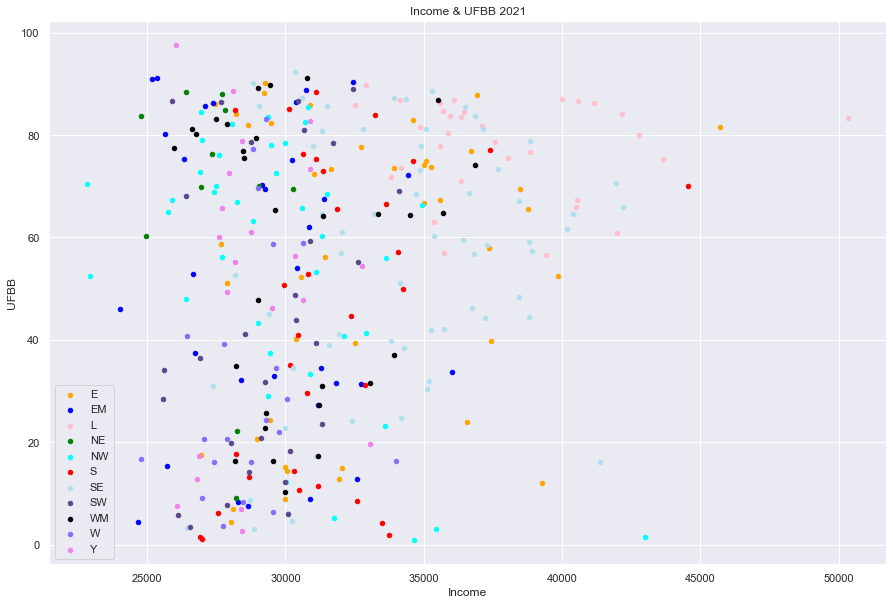

In [ ]:
#UFBB plot for 2021
fig = data_21[data_21.Region=='East'].plot(kind='scatter',x='Income',y='2021 UFBB availability (% premises)',color='orange', label='E')
data_21[data_21.Region=='East Midlands'].plot(kind='scatter',x='Income',y='2021 UFBB availability (% premises)',color='blue', label='EM', ax=fig)
data_21[data_21.Region=='London'].plot(kind='scatter',x='Income',y='2021 UFBB availability (% premises)',color='pink', label='L', ax=fig)
data_21[data_21.Region=='North East'].plot(kind='scatter',x='Income',y='2021 UFBB availability (% premises)',color='green', label='NE', ax=fig)
data_21[data_21.Region=='North West'].plot(kind='scatter',x='Income',y='2021 UFBB availability (% premises)',color='cyan', label='NW', ax=fig)
data_21[data_21.Region=='Scotland'].plot(kind='scatter',x='Income',y='2021 UFBB availability (% premises)',color='red', label='S', ax=fig)
data_21[data_21.Region=='South East'].plot(kind='scatter',x='Income',y='2021 UFBB availability (% premises)',color='#B2DFEE', label='SE', ax=fig)
data_21[data_21.Region=='South West'].plot(kind='scatter',x='Income',y='2021 UFBB availability (% premises)',color='#5D478B', label='SW', ax=fig)
data_21[data_21.Region=='West Midlands'].plot(kind='scatter',x='Income',y='2021 UFBB availability (% premises)',color='black', label='WM', ax=fig)
data_21[data_21.Region=='Wales'].plot(kind='scatter',x='Income',y='2021 UFBB availability (% premises)',color='#8470FF', label='W', ax=fig)
data_21[data_21.Region=='Yorkshire'].plot(kind='scatter',x='Income',y='2021 UFBB availability (% premises)',color='violet', label='Y', ax=fig)
fig.set_xlabel("Income")
fig.set_ylabel("UFBB")
fig.set_title("Income & UFBB 2021")
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show()

#### Depicting individual relationships in the UFBB plot

East: Random

East Midlands: Random 

London: Random 

North East: Random 

Scotland: Random 

North West: Random 

South East: Random 

South West: Random 

West Midlands: Random 

Wales: Weak Linear (outliers) 

Yorkshire: Random

#### Creating a scatterplot for FFBB

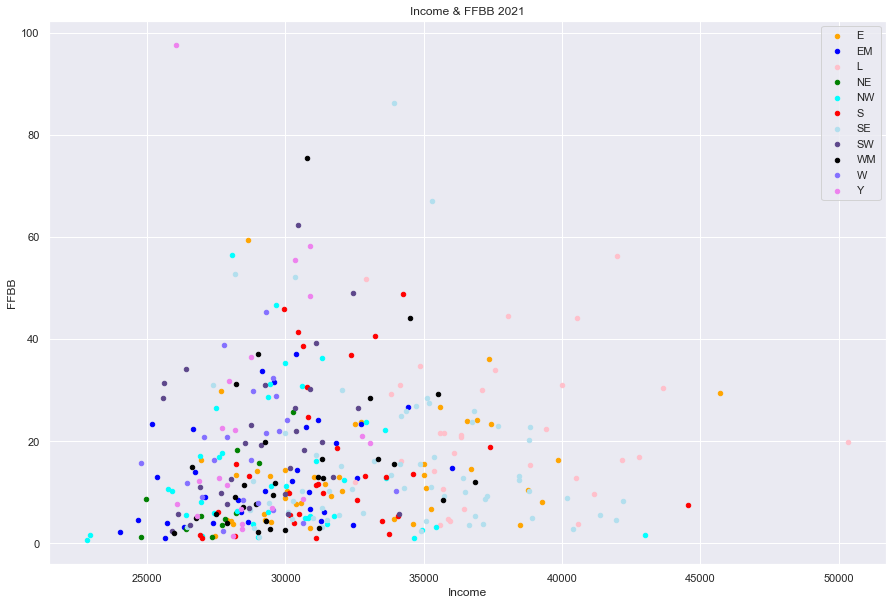

In [ ]:
#FFBB plot for 2021
fig = data_21[data_21.Region=='East'].plot(kind='scatter',x='Income',y='2021 FFBB availability (% premises)',color='orange', label='E')
data_21[data_21.Region=='East Midlands'].plot(kind='scatter',x='Income',y='2021 FFBB availability (% premises)',color='blue', label='EM', ax=fig)
data_21[data_21.Region=='London'].plot(kind='scatter',x='Income',y='2021 FFBB availability (% premises)',color='pink', label='L', ax=fig)
data_21[data_21.Region=='North East'].plot(kind='scatter',x='Income',y='2021 FFBB availability (% premises)',color='green', label='NE', ax=fig)
data_21[data_21.Region=='North West'].plot(kind='scatter',x='Income',y='2021 FFBB availability (% premises)',color='cyan', label='NW', ax=fig)
data_21[data_21.Region=='Scotland'].plot(kind='scatter',x='Income',y='2021 FFBB availability (% premises)',color='red', label='S', ax=fig)
data_21[data_21.Region=='South East'].plot(kind='scatter',x='Income',y='2021 FFBB availability (% premises)',color='#B2DFEE', label='SE', ax=fig)
data_21[data_21.Region=='South West'].plot(kind='scatter',x='Income',y='2021 FFBB availability (% premises)',color='#5D478B', label='SW', ax=fig)
data_21[data_21.Region=='West Midlands'].plot(kind='scatter',x='Income',y='2021 FFBB availability (% premises)',color='black', label='WM', ax=fig)
data_21[data_21.Region=='Wales'].plot(kind='scatter',x='Income',y='2021 FFBB availability (% premises)',color='#8470FF', label='W', ax=fig)
data_21[data_21.Region=='Yorkshire'].plot(kind='scatter',x='Income',y='2021 FFBB availability (% premises)',color='violet', label='Y', ax=fig)
fig.set_xlabel("Income")
fig.set_ylabel("FFBB")
fig.set_title("Income & FFBB 2021")
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show()

#### Depicting individual relationships in the FFBB plot

East: Random

East Midlands: Moderate Linear (outliers) 

London: Random 

North East: Random 

Scotland: Random 

North West: Random 

South East: Random 

South West: Weak positive Linear 

West Midlands: Weak positive Linear (Outliers) 

Wales: Random 

Yorkshire: Random

#### Correlation for 2021

<AxesSubplot:>

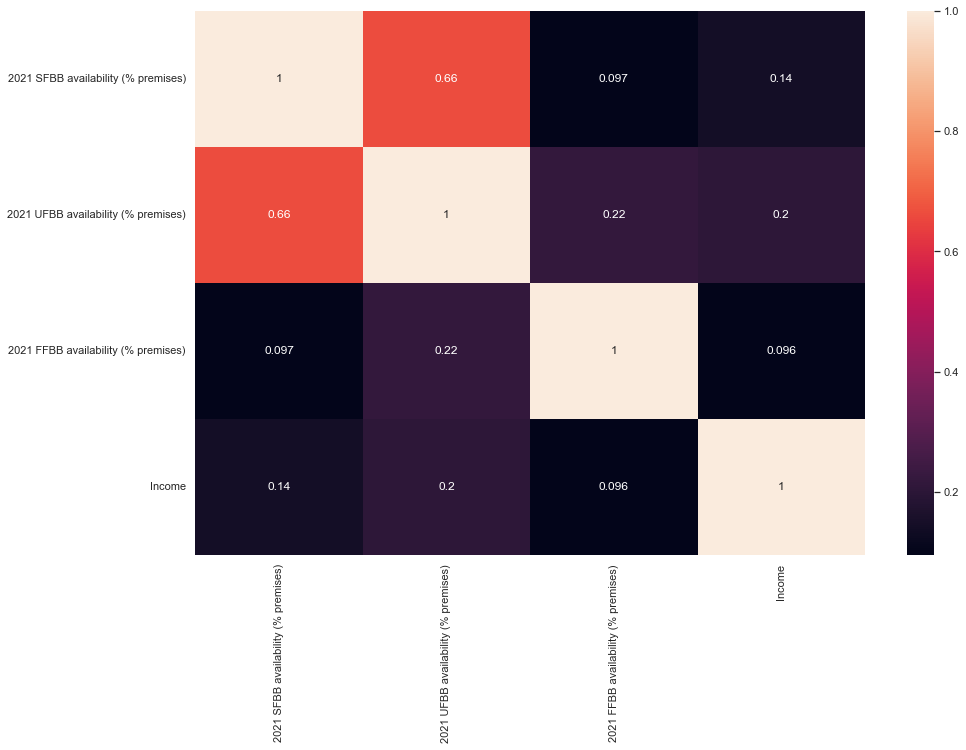

In [ ]:
# Correlation Matrix - to show correlations between variables, + 0.7 and above or -0.7 and below expresses a good correlation
plt.figure(figsize = (15,10))
correlation_matrix3 = data_21.corr() # returns a df

# Seaborn adds heatmap to visually highlight significant values in the matrix
sns.heatmap(data = correlation_matrix3, annot = True) 

#### Correlation Spectrum
Strength: Positive Negative Perfect 0.9 - 1.0 -0.9 to -1 

Strong 0.5 - 0.9 -0.5 to -0.9 

Weak  0.1 - 0.5 -0.1 to -0.5 No Corr. 0.0 - 0.1 0 to -0.1

Any correlation above 0.3 and below -0.3 is considered to be significant. However, there seem to be no significant relationships between income and intnernet availability 

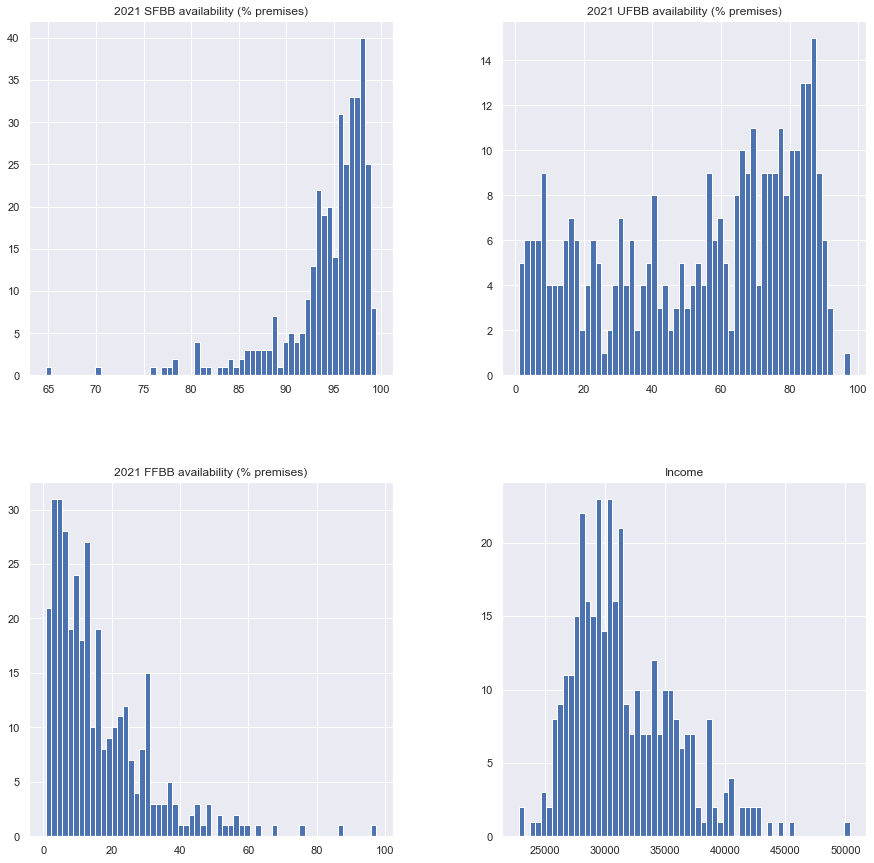

In [ ]:
# Histogram to assess distribution of data 2021

data_21.hist(bins=60, sharex=False, figsize=(15,15))
plt.show()

#### Interpreting the histograms

These histograms show all the data from 2021 for each variable. 

The histogram income looks similar to that depicted in question 2's analysis, with a similar positive kurtosis. The SFBB histogram shows a cluster around 100%, conveying that a majority of  regions have 100% SFBB availability. The UFBB plot for 2021 shows a spike around 90%. This greatly differs from the 2016-2021 UFBB histogram which showed a peak at 0%. However, Q2's data represented years before UFBB was readily available, and the 2021 data is expressing UFBB's current regional availabilty. The histogram for FFBB shows extremely low frequencies of data avialabilty around 30%, with outliers above 60%. This is due to FullFibre still being rolled out across the UK. It is the newest broadband type and is stil being established. Over time we would expect to see an increase in UFBB & FFBB availability across the UK, and positive skews in the distributions above.


